# Предсказание конечной температуры стали

Чтобы оптимизировать производственные расходы, металлургический комбинат решил уменьшить потребление электроэнергии на этапе обработки стали. Для этого комбинату нужно контролировать температуру сплава в его конечном состоянии. Небходимо построить модель, которая будет ее предсказывать

# Описание проекта 

Данные состоят из нескольких файлов, полученных из разных источников:

1. `data_arc_new.csv` — данные об электродах;

2. `data_bulk_new.csv` — данные о подаче сыпучих материалов (объём);
3. `data_bulk_time_new.csv` — данные о подаче сыпучих материалов (время);
4. `data_gas_new.csv` — данные о продувке сплава газом;
5. `data_temp_new.csv` — результаты измерения температуры;
6. `data_wire_new.csv` — данные о проволочных материалах (объём);
7. `data_wire_time_new.csv` — данные о проволочных материалах (время).

Ниже представлено содержание каждого из файлов: 

**1. Файл `data_arc_new.csv`**:

- `key` — номер партии;

- `Начало нагрева дугой` — время начала нагрева;
- `Конец нагрева дугой` — время окончания нагрева;
- `Активная мощность` — значение активной мощности;
- `Реактивная мощность` — значение реактивной мощности.


**2. Файл `data_bulk_new.csv`:**

- `key` — номер партии;

- `Bulk 1 … Bulk 15` — объём подаваемого материала.


**3. Файл `data_bulk_time_new.csv`:**

- `key` — номер партии;

- `Bulk 1 … Bulk 15` — время подачи материала.

**4. Файл `data_gas_new.csv`:**

- `key` — номер партии;

- `Газ 1` — объём подаваемого газа.

**5. Файл `data_temp_new.csv`**

- `key` — номер партии;

- `Время замера` — время замера;
- `Температура` — значение температуры.

**6. Файл `data_wire_new.csv`**

- `key` — номер партии;

- `Wire 1 … Wire 9` — объём подаваемых проволочных материалов.

**7. Файл `data_wire_time_new.csv`**

- `key` — номер партии;

- `Wire 1 … Wire 9` — время подачи проволочных материалов.

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

Планируется выполнить данную работу по следующей схеме: 
1. Первичная выгрузка данных и ознакомление с ними 
2. Предобработка данных
3. Объединение таблиц
4. Исследовательский и корреляционный анализ
5. Поиск наилучшей модели 
6. Общий вывод и рекомендации для заказчика

# Выгрузка и ознакомление с данными 

In [1]:
# Импорт необходимых библиотек
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import phik
import shap

# Преобразование и обработка данных
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (OneHotEncoder, 
                     StandardScaler, 
                     MinMaxScaler)
from sklearn.metrics import mean_absolute_error

# Импорт моделей
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
 
# Сброс ограничений на число столбцов
pd.set_option('display.max_columns', None)
 
# Сброс ограничений на количество символов в записи
pd.set_option('display.max_colwidth', None)


In [2]:
# Преобразование в датафреймы
data_arc = pd.read_csv('C://Users//79952/Desktop/Datasets/001_Температура/data_arc_new.csv')
data_bulk = pd.read_csv('C://Users//79952/Desktop/Datasets/001_Температура/data_bulk_new.csv')
data_bulk_time = pd.read_csv('C://Users//79952/Desktop/Datasets/001_Температура/data_bulk_time_new.csv')
data_gas = pd.read_csv('C://Users//79952/Desktop/Datasets/001_Температура/data_gas_new.csv')
data_temp = pd.read_csv('C://Users//79952/Desktop/Datasets/001_Температура/data_temp_new.csv')
data_wire = pd.read_csv('C://Users//79952/Desktop/Datasets/001_Температура/data_wire_new.csv')
data_wire_time = pd.read_csv('C://Users//79952/Desktop/Datasets/001_Температура/data_wire_time_new.csv')

In [3]:
# Вывод данных
datasets = {'data_arc': data_arc, 
           'data_bulk': data_bulk, 
           'data_bulk_time': data_bulk_time, 
           'data_gas': data_gas,
           'data_temp': data_temp,
           'data_wire': data_wire,
           'data_wire_time': data_wire_time}

for dataset_name, dataset in datasets.items(): 
    print('\n', '-'*40, f'Общая информация датасета {dataset_name}', '-'*40, '\n')
    dataset.info()
    print('\n', '-'*40, f'Содержание датасета {dataset_name}', '-'*40)
    display(dataset.head())


 ---------------------------------------- Общая информация датасета data_arc ---------------------------------------- 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB

 ---------------------------------------- Содержание датасета data_arc ----------------------------------------


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691



 ---------------------------------------- Общая информация датасета data_bulk ---------------------------------------- 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.3 KB

 --------------------------------

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0



 ---------------------------------------- Общая информация датасета data_bulk_time ---------------------------------------- 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.3+ KB

 ---------------------------------------- Соде

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47



 ---------------------------------------- Общая информация датасета data_gas ---------------------------------------- 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB

 ---------------------------------------- Содержание датасета data_gas ----------------------------------------


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692



 ---------------------------------------- Общая информация датасета data_temp ---------------------------------------- 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB

 ---------------------------------------- Содержание датасета data_temp ----------------------------------------


,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0



 ---------------------------------------- Общая информация датасета data_wire ---------------------------------------- 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB

 ---------------------------------------- Содержание датасета data_wire ----------------------------------------


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN



 ---------------------------------------- Общая информация датасета data_wire_time ---------------------------------------- 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB

 ---------------------------------------- Содержание датасета data_wire_time ----------------------------------------


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Вывод**: была получена первичная информация о датасетах, в них есть некоторые неточности: 
1. Некорректный стиль названий столбцов у датасетов
2. Неправильный тип данных в некторых столбцах
3. Есть пропуски

Теперь можно приступить к предобработке

# Предобработка данных 

## Корректировка стиля

Прежде всего необходимо привести все названия столбцов к единообразоному стилю, в данном случае snake case (названия на русском переводить не будем)

In [4]:
for dataset_name, dataset in datasets.items():
    dataset.columns = dataset.columns.str.lower().str.replace(' ','_')

In [5]:
for dataset_name, dataset in datasets.items():
    print(f'Столбцы датасета {dataset_name}:')
    print(*dataset.columns, sep=', ', end='\n\n')

Столбцы датасета data_arc:
key, начало_нагрева_дугой, конец_нагрева_дугой, активная_мощность, реактивная_мощность

Столбцы датасета data_bulk:
key, bulk_1, bulk_2, bulk_3, bulk_4, bulk_5, bulk_6, bulk_7, bulk_8, bulk_9, bulk_10, bulk_11, bulk_12, bulk_13, bulk_14, bulk_15

Столбцы датасета data_bulk_time:
key, bulk_1, bulk_2, bulk_3, bulk_4, bulk_5, bulk_6, bulk_7, bulk_8, bulk_9, bulk_10, bulk_11, bulk_12, bulk_13, bulk_14, bulk_15

Столбцы датасета data_gas:
key, газ_1

Столбцы датасета data_temp:
key, время_замера, температура

Столбцы датасета data_wire:
key, wire_1, wire_2, wire_3, wire_4, wire_5, wire_6, wire_7, wire_8, wire_9

Столбцы датасета data_wire_time:
key, wire_1, wire_2, wire_3, wire_4, wire_5, wire_6, wire_7, wire_8, wire_9



Столбцы успешно переименованы

## Изменение типов данных 

Необходимо перевести временные данные к типу `datetime`, к ним относятся столбцы: 
- `начало_нагрева_дугой`, `конец_нагрева_дугой` в датасете `data_arc`

- Столбцы `bulk_1...bulk_15` в датасете `data_bulk_time`
- `время_замера` в датасете `data_temp`
- Столбцы `wire_1...wire_9` в датасете `data_wire_time`

Преобразуем столбцы со временем в `data_bulk_time` и `data_wire_time` в разницу между данным временем и датой 2019-05-01 00:00:00. Это позволит нам корректно работать с временными признаками

In [6]:
def make_datetime(dataset, col): 
    dataset[col] = pd.to_datetime(dataset[col])

In [7]:
make_datetime(data_arc, 'начало_нагрева_дугой')
make_datetime(data_arc, 'конец_нагрева_дугой')
make_datetime(data_temp, 'время_замера')

for i in range(1, 16): 
    make_datetime(data_bulk_time, f'bulk_{i}')
    
for i in range(1, 10): 
    make_datetime(data_wire_time, f'wire_{i}')

In [8]:
for i in [data_arc, data_temp, data_bulk_time, data_wire_time]: 
    i.info()
    print('*' * 50)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14876 non-null  int64         
 1   начало_нагрева_дугой  14876 non-null  datetime64[ns]
 2   конец_нагрева_дугой   14876 non-null  datetime64[ns]
 3   активная_мощность     14876 non-null  float64       
 4   реактивная_мощность   14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB
**************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           18092 non-null  int64         
 1   время_замера  18092 non-null  datetime64[ns]
 2   температура   14665 non-null  float64       
dtypes

**Вывод**: тип данных успешно скорректирован 

## Обработка пропусков

В исходных датасетах было обнаружено большое количество пропусков. Их необходимо обработать

In [9]:
for dataset_name, dataset in datasets.items():
    print(f'Количество пропусков в датасете {dataset_name}')
    print(dataset.isna().sum())
    print('-'*50)

Количество пропусков в датасете data_arc
key                     0
начало_нагрева_дугой    0
конец_нагрева_дугой     0
активная_мощность       0
реактивная_мощность     0
dtype: int64
--------------------------------------------------
Количество пропусков в датасете data_bulk
key           0
bulk_1     2877
bulk_2     3107
bulk_3     1831
bulk_4     2115
bulk_5     3052
bulk_6     2553
bulk_7     3104
bulk_8     3128
bulk_9     3110
bulk_10    2953
bulk_11    2952
bulk_12     679
bulk_13    3111
bulk_14     323
bulk_15     881
dtype: int64
--------------------------------------------------
Количество пропусков в датасете data_bulk_time
key           0
bulk_1     2877
bulk_2     3107
bulk_3     1831
bulk_4     2115
bulk_5     3052
bulk_6     2553
bulk_7     3104
bulk_8     3128
bulk_9     3110
bulk_10    2953
bulk_11    2952
bulk_12     679
bulk_13    3111
bulk_14     323
bulk_15     881
dtype: int64
--------------------------------------------------
Количество пропусков в датасете data

Обнаружено большое количество пропусков в датасетах `data_bulk`, `data_bulk_time`, `data_temp`, `data_wire`, `data_wire_time`. Однако все они имеют схожую природу. Скорее всего пропуски обуславливаются отсутствием подачи материала. Будет корректно поставить на это место заглушки. Пропуски в датасете `data_temp` требуют отдельного рассмотрения

In [10]:
lst = [data_bulk, data_bulk_time, data_wire, data_wire_time]
data_bulk, data_bulk_time, data_wire, data_wire_time = [l.fillna(0) for l in lst]

В датасете `data_temp` пропуски стоят на месте целевого признака. Рассмотрим их детальнее

In [11]:
data_temp[data_temp.isna().any(axis=1)]

,key,время_замера,температура
13927,2500,2019-08-10 14:13:11,NaN
13928,2500,2019-08-10 14:18:12,NaN
13929,2500,2019-08-10 14:25:53,NaN
13930,2500,2019-08-10 14:29:39,NaN
13932,2501,2019-08-10 14:49:15,NaN
...,...,...,...
18087,3241,2019-09-06 16:55:01,NaN
18088,3241,2019-09-06 17:06:38,NaN
18089,3241,2019-09-06 17:21:48,NaN
18090,3241,2019-09-06 17:24:44,NaN


В данном случае придется удалить отсутствующие значение, так как мы никак не можем заменить эти значения (это целевой признак). Удалять следует именно объект моделирования, то есть если отсутствует хотя бы одна строка по ключу в колонке с температурой, то удаляем весь ключ

In [12]:
# Ключи, которые необходимо удалить
keys_drop = data_temp[data_temp.isna().any(axis=1)]['key'].unique()
keys_drop[:10]

array([2500, 2501, 2502, 2503, 2504, 2505, 2506, 2507, 2508, 2509],
      dtype=int64)

In [13]:
data_temp = data_temp.query('key not in @keys_drop')

print(f'Количество ключей с неизвестной температурой: {len(data_temp[data_temp.isna().any(axis=1)])}')

Количество ключей с неизвестной температурой: 0


In [14]:
for i in [data_bulk, data_bulk_time, data_wire, data_wire_time, data_temp]: 
    print(i.isna().sum())

key        0
bulk_1     0
bulk_2     0
bulk_3     0
bulk_4     0
bulk_5     0
bulk_6     0
bulk_7     0
bulk_8     0
bulk_9     0
bulk_10    0
bulk_11    0
bulk_12    0
bulk_13    0
bulk_14    0
bulk_15    0
dtype: int64
key        0
bulk_1     0
bulk_2     0
bulk_3     0
bulk_4     0
bulk_5     0
bulk_6     0
bulk_7     0
bulk_8     0
bulk_9     0
bulk_10    0
bulk_11    0
bulk_12    0
bulk_13    0
bulk_14    0
bulk_15    0
dtype: int64
key       0
wire_1    0
wire_2    0
wire_3    0
wire_4    0
wire_5    0
wire_6    0
wire_7    0
wire_8    0
wire_9    0
dtype: int64
key       0
wire_1    0
wire_2    0
wire_3    0
wire_4    0
wire_5    0
wire_6    0
wire_7    0
wire_8    0
wire_9    0
dtype: int64
key             0
время_замера    0
температура     0
dtype: int64


**Вывод**: Пропуски успешно обработаны

## Обработка дубликатов 

In [15]:
datasets = {'data_arc': data_arc, 
           'data_bulk': data_bulk, 
           'data_bulk_time': data_bulk_time, 
           'data_gas': data_gas,
           'data_temp': data_temp,
           'data_wire': data_wire,
           'data_wire_time': data_wire_time}

for dataset_name, dataset in datasets.items(): 
    print(f'Дубликаты датасета {dataset_name}: {dataset.duplicated().sum()}')

Дубликаты датасета data_arc: 0
Дубликаты датасета data_bulk: 0
Дубликаты датасета data_bulk_time: 0
Дубликаты датасета data_gas: 0
Дубликаты датасета data_temp: 0
Дубликаты датасета data_wire: 0
Дубликаты датасета data_wire_time: 0


**Вывод**: явных дублей не обнаружено

# Первичный исследовательский анализ 

In [16]:
# Функция для исследовательского анализа количественных признаков

def EDA_numeric(dataset, feature, bins=30, kde=True):
    
    print('Описательная статистика: ' + feature)
    display(dataset[feature].describe())
    
    plt.figure(figsize=(10,5))
    sns.histplot(data=dataset, x=feature, bins=bins, kde=kde)
    plt.title('Гистограмма признака: ' + feature)
    plt.xlabel(feature)
    plt.ylabel('Частота')
    plt.show()

    plt.figure(figsize=(10,2))
    sns.boxplot(data=dataset, x=feature)
    plt.title('Боксплот признака: ' + feature)
    plt.show()

## Датасет `data_arc`

### Активная мощность

Описательная статистика: активная_мощность


count    14876.000000
mean         0.662752
std          0.258885
min          0.223120
25%          0.467115
50%          0.599587
75%          0.830070
max          1.463773
Name: активная_мощность, dtype: float64

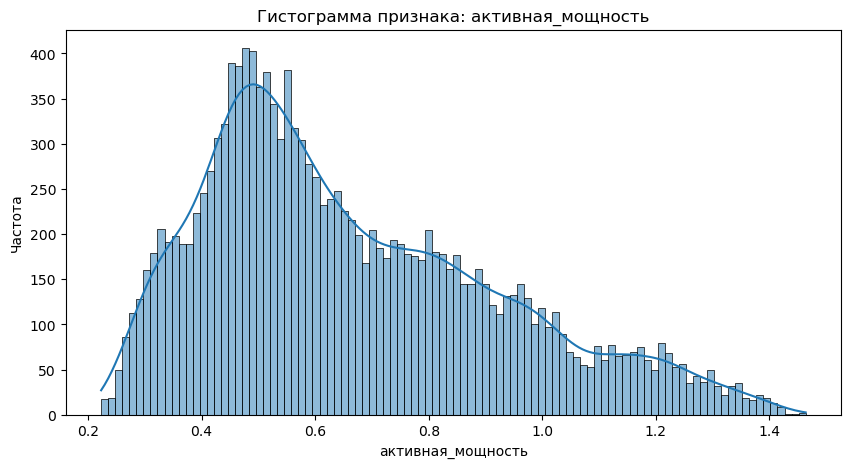

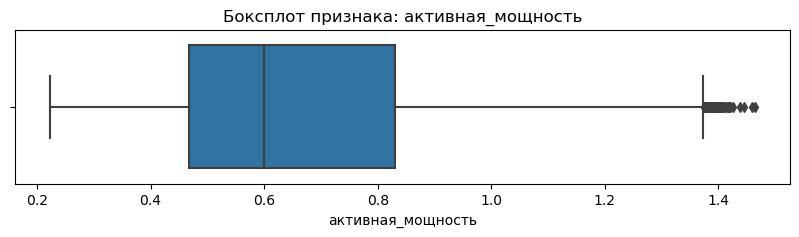

In [17]:
EDA_numeric(data_arc, 'активная_мощность', bins=100)

**Вывод**: В среднем активная мощность 0,66, что не сильно далеко от медианы 0,55. Явных выбросов нет

### Реактивная мощность

Описательная статистика: реактивная_мощность


count    14876.000000
mean         0.438986
std          5.873485
min       -715.479924
25%          0.337175
50%          0.441639
75%          0.608201
max          1.270284
Name: реактивная_мощность, dtype: float64

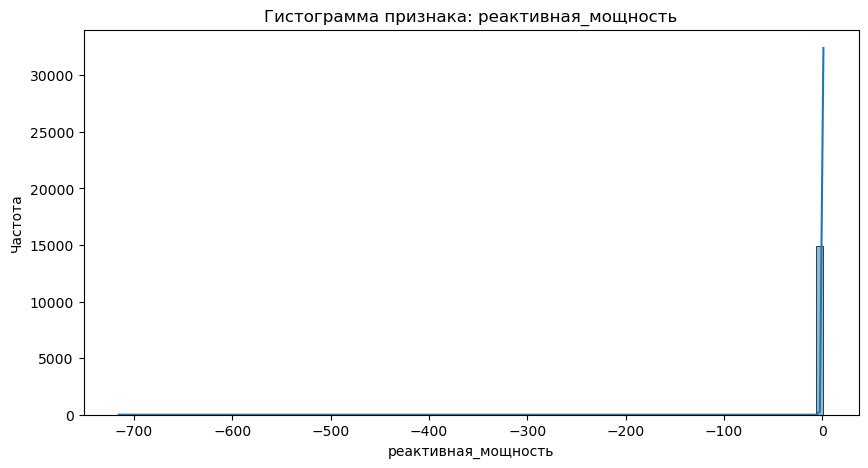

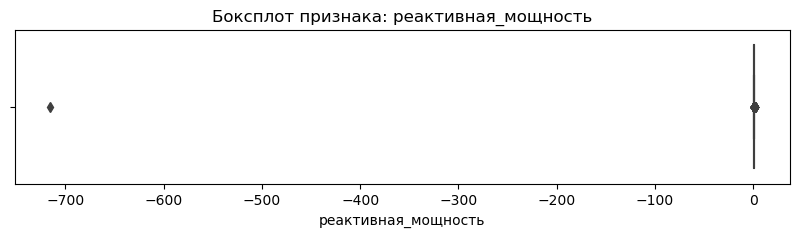

In [18]:
EDA_numeric(data_arc, 'реактивная_мощность', bins=100)

**Вывод**: обаружена аномалия. Ограничим нижний порог реактивной мощности до 0

In [19]:
data_arc = data_arc.query('реактивная_мощность >= 0')

Описательная статистика: реактивная_мощность


count    14875.000000
mean         0.487115
std          0.197612
min          0.153777
25%          0.337190
50%          0.441665
75%          0.608223
max          1.270284
Name: реактивная_мощность, dtype: float64

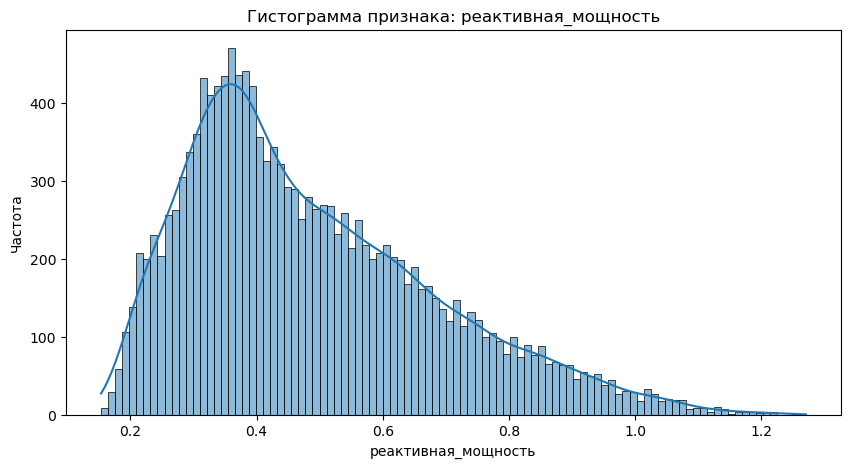

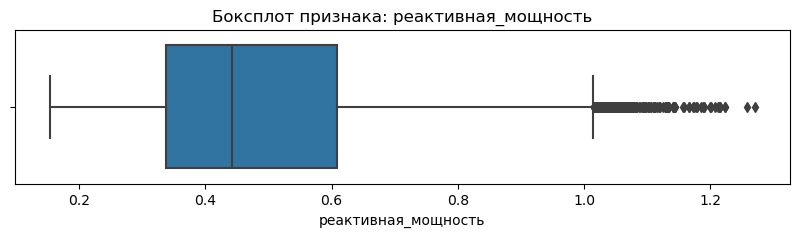

In [20]:
EDA_numeric(data_arc, 'реактивная_мощность', bins=100)

**Вывод**: Аномальные значения удалены. Распределение реактивной мощности похоже на распределение активной, но среднее и медиана меньше. Явных выборосов нет

## Датасет `data_gas`

### Газ

Описательная статистика: газ_1


count    3239.000000
mean       11.002062
std         6.220327
min         0.008399
25%         7.043089
50%         9.836267
75%        13.769915
max        77.995040
Name: газ_1, dtype: float64

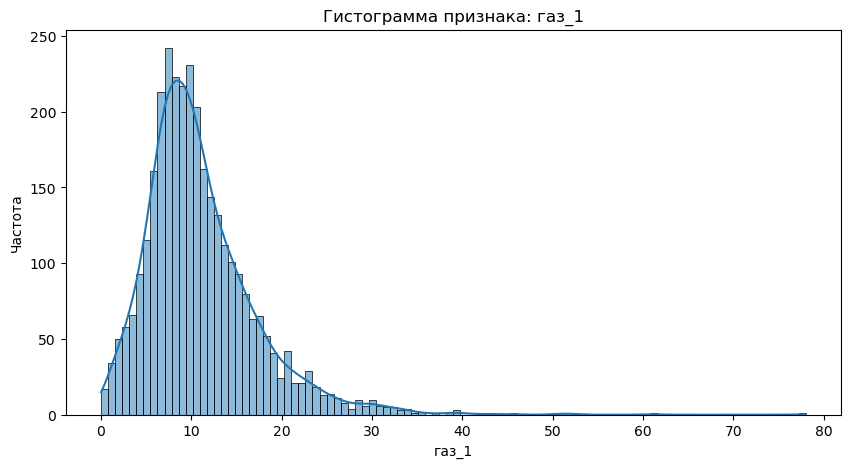

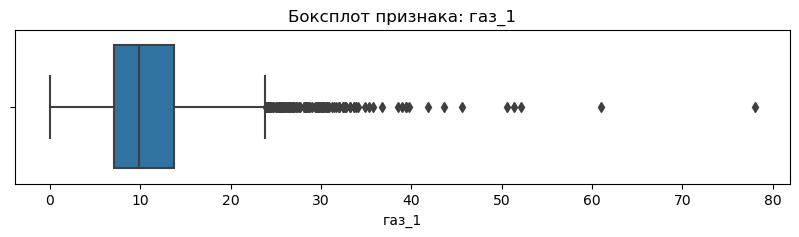

In [21]:
EDA_numeric(data_gas, 'газ_1', bins=100)

**Вывод**: распределение напоминает нормальное со сдвигом влево. Боксплот показывает выбросы, однако они не являются таковыми с точки зрения логики. Оставим все как есть

## Датасет `data_temp`

### Температура

Описательная статистика: температура


count    13926.000000
mean      1590.802671
std         19.845377
min       1191.000000
25%       1580.000000
50%       1590.000000
75%       1599.000000
max       1705.000000
Name: температура, dtype: float64

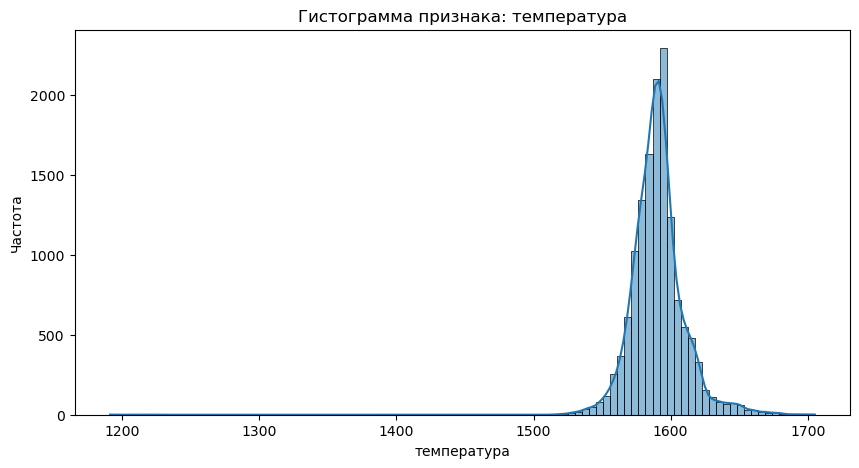

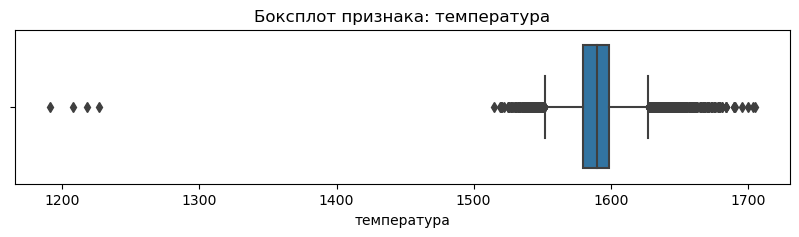

In [22]:
EDA_numeric(data_temp, 'температура', bins=100)

**Вывод**: есть аномальные значения, также температура не может быть ниже 1400, так как это нижний предел температуры плавления стали. При температурах ниже этой, сталь будет иметь твердое агрегатное состояние

In [23]:
data_temp = data_temp.query('температура >= 1400')

Описательная статистика: температура


count    13922.000000
mean      1590.911794
std         18.773405
min       1515.000000
25%       1580.000000
50%       1590.000000
75%       1599.000000
max       1705.000000
Name: температура, dtype: float64

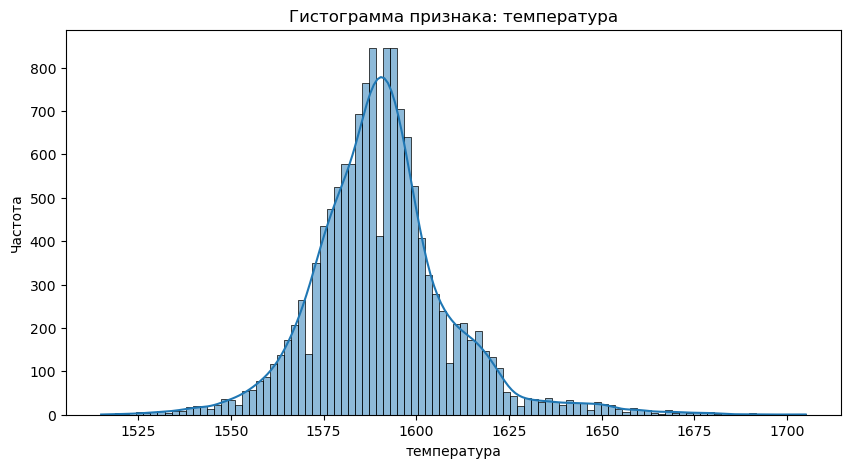

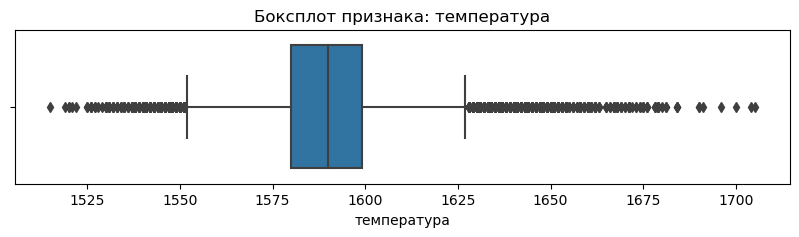

In [24]:
EDA_numeric(data_temp, 'температура', bins=100)

**Вывод**: распределение напоминает нормальное. Среднее и медиана практически равны друг другу (1590). Аномальные значения исключены

# Объединение датасетов 

Объединим все датасеты по ключу `key`. Оставляем в итоговом датасете только последнюю температуру в партии (это и будет целевым признаком в далее)

Необходимо скорректировать некоторые признаки. Например признак `время замера` не является информативным. Избавимся от него

In [25]:
data_temp = data_temp.drop('время_замера', axis=1)
print(f'Размерность таблицы: {data_temp.shape}')
data_temp.head(7)

Размерность таблицы: (13922, 2)


,key,температура
0,1,1571.0
1,1,1604.0
2,1,1618.0
3,1,1601.0
4,1,1606.0
5,1,1613.0
6,2,1581.0


Сгруппируем данные по ключу, воспользуемся функцией агрегации, которая оставит последнее значение и первое значение объекта моделирования

In [26]:
data_temp = data_temp.groupby(by='key').agg(['first', 'last'])
data_temp = data_temp.droplevel(0, axis=1)
print(f'Размерность полученной таблицы: {data_temp.shape}')
data_temp.head()

Размерность полученной таблицы: (2477, 2)


,first,last
key,,
1,1571.0,1613.0
2,1581.0,1602.0
3,1596.0,1599.0
4,1601.0,1625.0
5,1576.0,1602.0


In [27]:
data_temp = data_temp.rename(columns={'first':'temp_first', 
                                     'last': 'temp_last'})

In [28]:
data_temp.head()

,temp_first,temp_last
key,,
1,1571.0,1613.0
2,1581.0,1602.0
3,1596.0,1599.0
4,1601.0,1625.0
5,1576.0,1602.0


Теперь можно начать объединять по ключу

Также не будем учитывать временные параметры (`data_bulk_time`, `data_wire_time`)

## Присоединение `data_arc` 

Здесь необходима определенная корректировка признаков. Оставим среднее время нагрева дугой (найдем разницу во времени в каждой строке, потом усрденим ее). Активную и реактивную мощность примем за среднее и добавим полную мощность к таблице

In [29]:
data_arc.head()

,key,начало_нагрева_дугой,конец_нагрева_дугой,активная_мощность,реактивная_мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


In [30]:
data_arc['time'] = data_arc['конец_нагрева_дугой'] - data_arc['начало_нагрева_дугой']
data_arc = data_arc.drop(['начало_нагрева_дугой', 'конец_нагрева_дугой'], axis=1)

C:\Users\79952\AppData\Local\Temp\ipykernel_16420\2387017223.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_arc['time'] = data_arc['конец_нагрева_дугой'] - data_arc['начало_нагрева_дугой']


In [31]:
data_arc.head()

,key,активная_мощность,реактивная_мощность,time
0,1,0.305130,0.211253,0 days 00:03:48
1,1,0.765658,0.477438,0 days 00:03:05
2,1,0.580313,0.430460,0 days 00:02:52
3,1,0.518496,0.379979,0 days 00:06:05
4,1,0.867133,0.643691,0 days 00:02:28


Приведем полученное время к количеству секунд

In [32]:
data_arc['time'] = data_arc['time'].apply(lambda x: x.total_seconds())

In [33]:
data_arc.head()

,key,активная_мощность,реактивная_мощность,time
0,1,0.305130,0.211253,228.0
1,1,0.765658,0.477438,185.0
2,1,0.580313,0.430460,172.0
3,1,0.518496,0.379979,365.0
4,1,0.867133,0.643691,148.0


In [34]:
# Агрегирование значений
data_arc = data_arc.groupby(by='key').sum()
data_arc.head()

,активная_мощность,реактивная_мощность,time
key,,,
1,3.036730,2.142821,1098.0
2,2.139408,1.453357,811.0
3,4.063641,2.937457,655.0
4,2.706489,2.056992,741.0
5,2.252950,1.687991,869.0


In [35]:
# Функция для проверки на размерность
def shape_validation(total_data, left_data, right_data): 
    d = {'Размерность': [left_data.shape, right_data.shape, total_data.shape]}
    print(pd.DataFrame(d, index=['левая_таблица', 'правая_таблица', 'итоговая_таблица']), '\n')
    
    if total_data.shape[0] == left_data.shape[0]: 
        print('Размерность корректна')
    else: 
        print('Размерность некорректна')

In [36]:
# Объединение
data_1 = data_temp.merge(data_arc, on='key', how='left')
shape_validation(data_1, data_temp, data_arc)

                 Размерность
левая_таблица      (2477, 2)
правая_таблица     (3214, 3)
итоговая_таблица   (2477, 5) 

Размерность корректна


In [37]:
data_1.head()

,temp_first,temp_last,активная_мощность,реактивная_мощность,time
key,,,,,
1,1571.0,1613.0,3.036730,2.142821,1098.0
2,1581.0,1602.0,2.139408,1.453357,811.0
3,1596.0,1599.0,4.063641,2.937457,655.0
4,1601.0,1625.0,2.706489,2.056992,741.0
5,1576.0,1602.0,2.252950,1.687991,869.0


## Присоединение `data_bulk`

In [38]:
# Объединение
data_2 = data_1.merge(data_bulk, on='key', how='left')
shape_validation(data_2, data_1, data_arc)

                 Размерность
левая_таблица      (2477, 5)
правая_таблица     (3214, 3)
итоговая_таблица  (2477, 21) 

Размерность корректна


In [39]:
data_2.head()

,key,temp_first,temp_last,активная_мощность,реактивная_мощность,time,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,1571.0,1613.0,3.036730,2.142821,1098.0,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,2,1581.0,1602.0,2.139408,1.453357,811.0,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,3,1596.0,1599.0,4.063641,2.937457,655.0,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
3,4,1601.0,1625.0,2.706489,2.056992,741.0,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
4,5,1576.0,1602.0,2.252950,1.687991,869.0,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0


## Присоедиение `data_gas` 

In [40]:
# Объединение
data_3 = data_2.merge(data_gas, on='key', how='left')
shape_validation(data_3, data_2, data_gas)

                 Размерность
левая_таблица     (2477, 21)
правая_таблица     (3239, 2)
итоговая_таблица  (2477, 22) 

Размерность корректна


In [41]:
data_3.head()

,key,temp_first,temp_last,активная_мощность,реактивная_мощность,time,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,газ_1
0,1,1571.0,1613.0,3.036730,2.142821,1098.0,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,29.749986
1,2,1581.0,1602.0,2.139408,1.453357,811.0,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,12.555561
2,3,1596.0,1599.0,4.063641,2.937457,655.0,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,28.554793
3,4,1601.0,1625.0,2.706489,2.056992,741.0,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,18.841219
4,5,1576.0,1602.0,2.252950,1.687991,869.0,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,5.413692


## Присоединение `data_wire` 

In [42]:
# Объединение
data_4 = data_3.merge(data_wire, on='key', how='left')
shape_validation(data_4, data_3, data_wire)

                 Размерность
левая_таблица     (2477, 22)
правая_таблица    (3081, 10)
итоговая_таблица  (2477, 31) 

Размерность корректна


In [43]:
data_4.head()

,key,temp_first,temp_last,активная_мощность,реактивная_мощность,time,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,газ_1,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,1571.0,1613.0,3.036730,2.142821,1098.0,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,29.749986,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,1581.0,1602.0,2.139408,1.453357,811.0,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,12.555561,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,1596.0,1599.0,4.063641,2.937457,655.0,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,28.554793,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,1601.0,1625.0,2.706489,2.056992,741.0,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,18.841219,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,1576.0,1602.0,2.252950,1.687991,869.0,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,5.413692,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
data = data_4

In [45]:
# Проверка на пропуски
data.isna().sum()

key                      0
temp_first               0
temp_last                0
активная_мощность        2
реактивная_мощность      2
time                     2
bulk_1                  69
bulk_2                  69
bulk_3                  69
bulk_4                  69
bulk_5                  69
bulk_6                  69
bulk_7                  69
bulk_8                  69
bulk_9                  69
bulk_10                 69
bulk_11                 69
bulk_12                 69
bulk_13                 69
bulk_14                 69
bulk_15                 69
газ_1                    2
wire_1                 104
wire_2                 104
wire_3                 104
wire_4                 104
wire_5                 104
wire_6                 104
wire_7                 104
wire_8                 104
wire_9                 104
dtype: int64

In [46]:
data = data.dropna()

In [47]:
data.isna().sum()

key                    0
temp_first             0
temp_last              0
активная_мощность      0
реактивная_мощность    0
time                   0
bulk_1                 0
bulk_2                 0
bulk_3                 0
bulk_4                 0
bulk_5                 0
bulk_6                 0
bulk_7                 0
bulk_8                 0
bulk_9                 0
bulk_10                0
bulk_11                0
bulk_12                0
bulk_13                0
bulk_14                0
bulk_15                0
газ_1                  0
wire_1                 0
wire_2                 0
wire_3                 0
wire_4                 0
wire_5                 0
wire_6                 0
wire_7                 0
wire_8                 0
wire_9                 0
dtype: int64

**Вывод**: Итоговая таблица готова

In [48]:
data

,key,temp_first,temp_last,активная_мощность,реактивная_мощность,time,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,газ_1,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,1571.0,1613.0,3.036730,2.142821,1098.0,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,29.749986,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,1581.0,1602.0,2.139408,1.453357,811.0,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,12.555561,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,1596.0,1599.0,4.063641,2.937457,655.0,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,28.554793,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,1601.0,1625.0,2.706489,2.056992,741.0,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,18.841219,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,1576.0,1602.0,2.252950,1.687991,869.0,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,5.413692,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2472,2495,1570.0,1591.0,3.168133,2.210936,723.0,0.0,0.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0,90.0,0.0,256.0,0.0,129.0,223.0,7.125735,89.150879,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2473,2496,1554.0,1591.0,4.174918,2.872031,940.0,0.0,0.0,0.0,63.0,0.0,0.0,0.0,0.0,0.0,122.0,0.0,256.0,0.0,129.0,226.0,9.412616,114.179527,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2474,2497,1571.0,1589.0,3.605239,2.452092,569.0,0.0,0.0,0.0,85.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,230.0,0.0,124.0,226.0,6.271699,94.086723,9.04800,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2475,2498,1591.0,1594.0,3.202310,2.239820,750.0,0.0,0.0,90.0,0.0,0.0,0.0,0.0,0.0,0.0,101.0,0.0,206.0,0.0,129.0,207.0,14.953657,118.110717,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Исследовательский анализ

Проведем исследовательский анализ полученной таблицы

In [49]:
# Функция для исследовательского анализа количественных признаков

def EDA_numeric(dataset, feature, bins=30, kde=True):
    
    print('Описательная статистика: ' + feature)
    display(dataset[feature].describe())
    
    plt.figure(figsize=(10,3))
    sns.histplot(data=dataset, x=feature, bins=bins, kde=kde)
    plt.title('Гистограмма признака: ' + feature)
    plt.xlabel(feature)
    plt.ylabel('Частота')
    plt.show()

    plt.figure(figsize=(10,1))
    sns.boxplot(data=dataset, x=feature)
    plt.title('Боксплот признака: ' + feature)
    plt.show()

Описательная статистика: temp_first


count    2329.000000
mean     1587.386003
std        23.619841
min      1519.000000
25%      1571.000000
50%      1587.000000
75%      1603.000000
max      1660.000000
Name: temp_first, dtype: float64

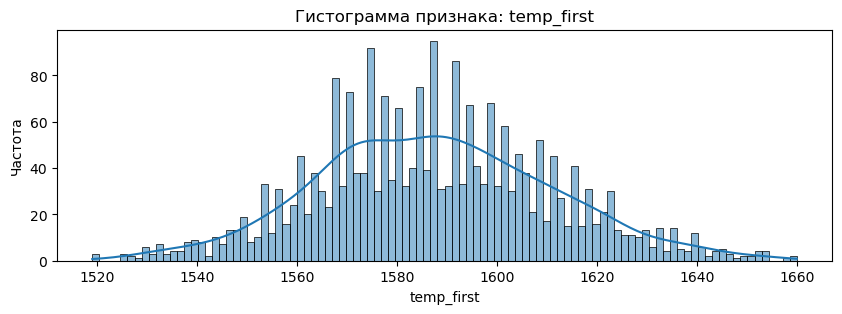

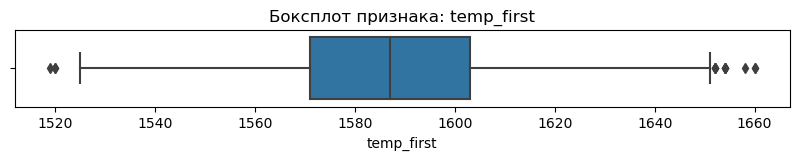

In [50]:
EDA_numeric(data, 'temp_first', bins=100)

**Вывод**: распределение начальной температуры напоминает пологое нормальное распределение с высокой дисперсией. Аномальных выбросов не наблюдается

Описательная статистика: temp_last


count    2329.000000
mean     1593.365393
std        11.200915
min      1541.000000
25%      1587.000000
50%      1593.000000
75%      1598.000000
max      1653.000000
Name: temp_last, dtype: float64

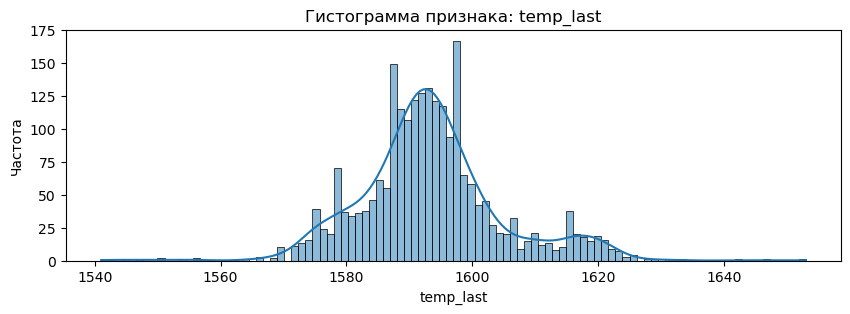

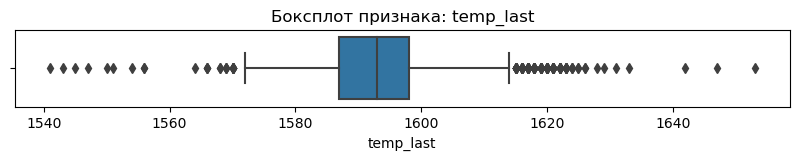

In [51]:
EDA_numeric(data, 'temp_last', bins=100)

**Вывод**: Боксплот показал выбросы, однако они не являются аномальными, оставим их. Стандартное отклонение в конечной температуре намного меньше, чем в начальной

Описательная статистика: активная_мощность


count    2329.000000
mean        3.125033
std         1.221007
min         0.267676
25%         2.293900
50%         3.035365
75%         3.834300
max        12.375636
Name: активная_мощность, dtype: float64

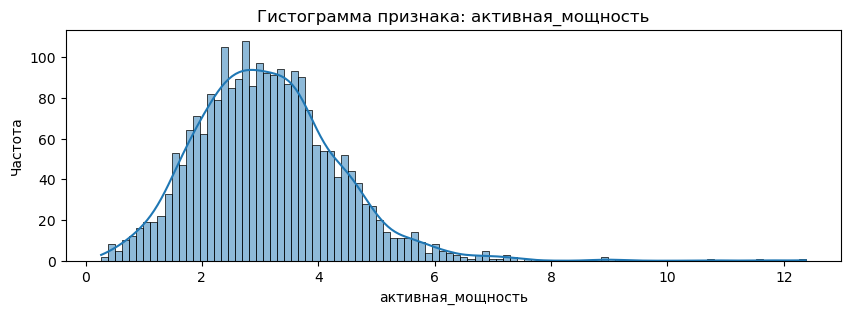

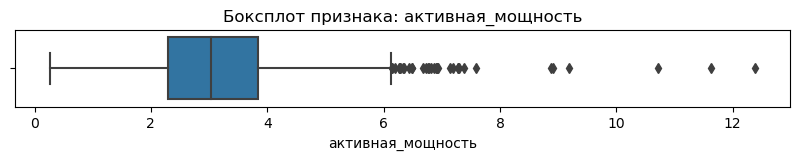

In [52]:
EDA_numeric(data, 'активная_мощность', bins=100)

**Вывод**: Распределение активной мощности напоминает нормальным с большим стандартным отклонением

Описательная статистика: реактивная_мощность


count    2329.000000
mean        2.300522
std         0.903968
min         0.196228
25%         1.669572
50%         2.225398
75%         2.829159
max         8.949049
Name: реактивная_мощность, dtype: float64

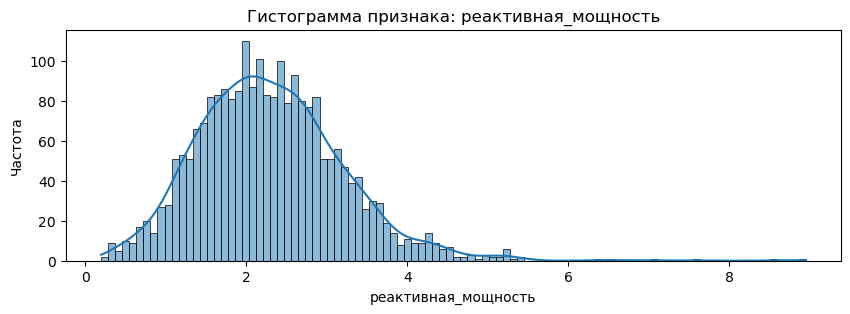

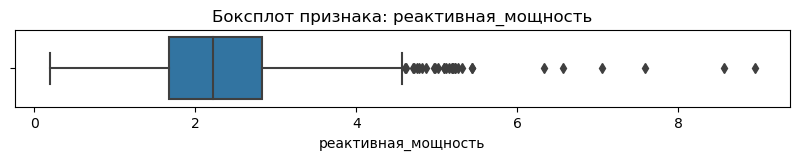

In [53]:
EDA_numeric(data, 'реактивная_мощность', bins=100)

**Вывод**: Распределение реактивной мощности напоминает нормальным с большим стандартным отклонением

Описательная статистика: time


count    2329.000000
mean      807.600687
std       340.897332
min        57.000000
25%       581.000000
50%       778.000000
75%       993.000000
max      4189.000000
Name: time, dtype: float64

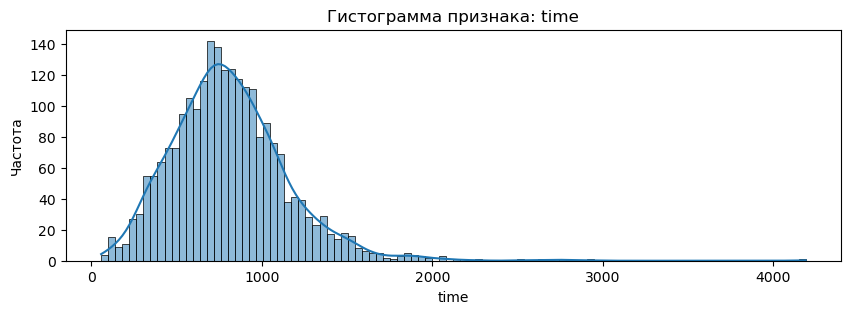

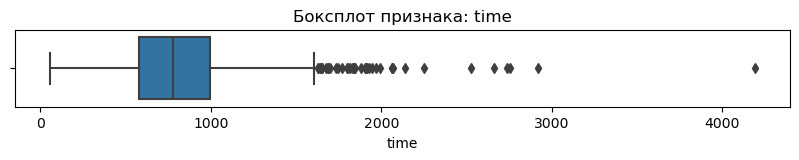

In [54]:
EDA_numeric(data, 'time', bins=100)

**Вывод**: Распределение среднего времени за цикл мощности напоминает нормальным с большим стандартным отклонением

Описательная статистика: газ_1


count    2329.000000
mean       11.375600
std         6.392041
min         0.008399
25%         7.282948
50%        10.100950
75%        14.216688
max        77.995040
Name: газ_1, dtype: float64

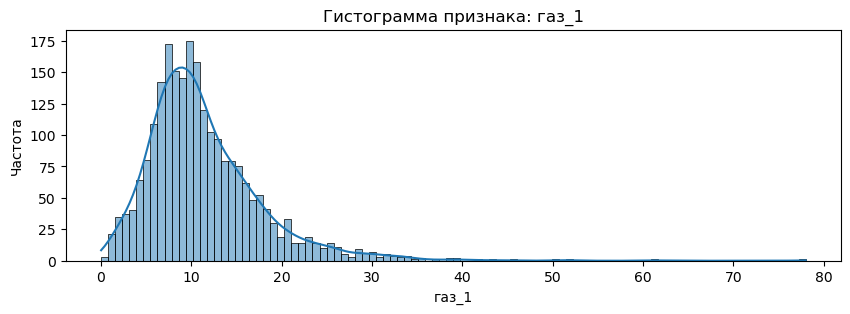

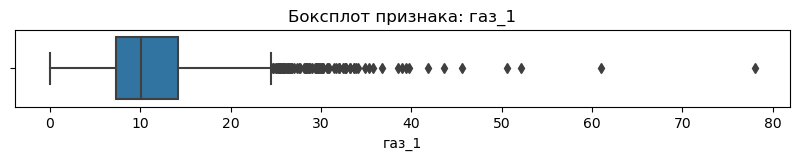

In [55]:
EDA_numeric(data, 'газ_1', bins=100)

**Вывод**: Распределение газа напоминает нормальное со смещением влево

## `bulk_1...bulk_15`

Если процент нулевых значений в объеме сыпучих материалов будет больше 95%, то будем объединять их в признак `bulk_rare`

Процент нулевых значений в bulk_1: 91.46%
Описательная статистика: bulk_1


count    2329.000000
mean        3.427651
std        12.412132
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       185.000000
Name: bulk_1, dtype: float64

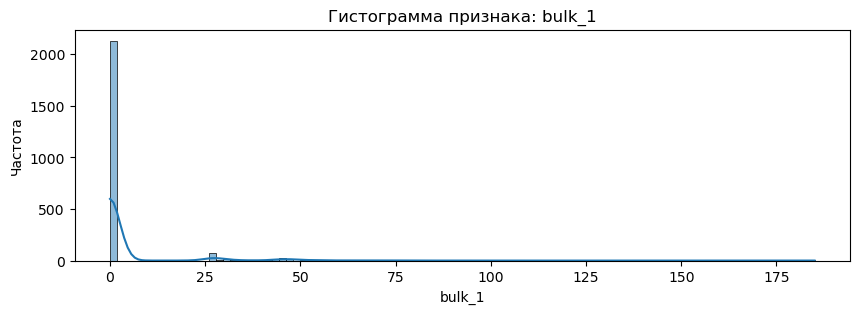

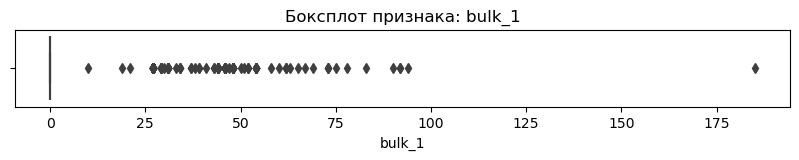

--------------------------------------------------------------------------------------------------------------
Процент нулевых значений в bulk_2: 99.44%
Описательная статистика: bulk_2


count    2329.000000
mean        1.422499
std        19.082119
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       325.000000
Name: bulk_2, dtype: float64

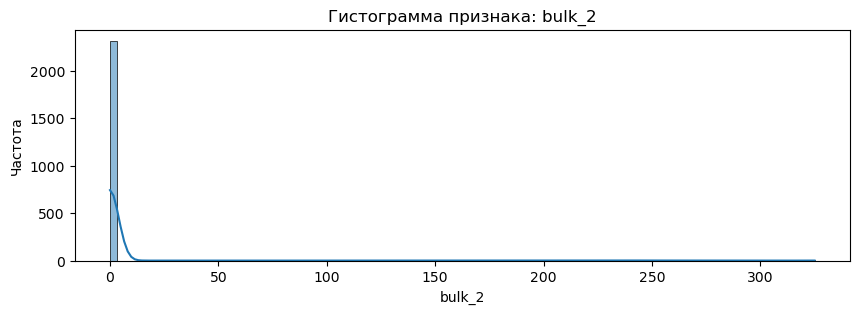

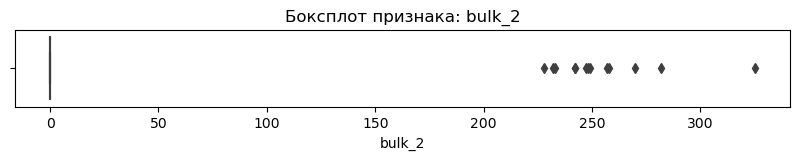

--------------------------------------------------------------------------------------------------------------
Процент нулевых значений в bulk_3: 58.78%
Описательная статистика: bulk_3


count    2329.000000
mean       47.348218
std        75.310430
min         0.000000
25%         0.000000
50%         0.000000
75%        80.000000
max       454.000000
Name: bulk_3, dtype: float64

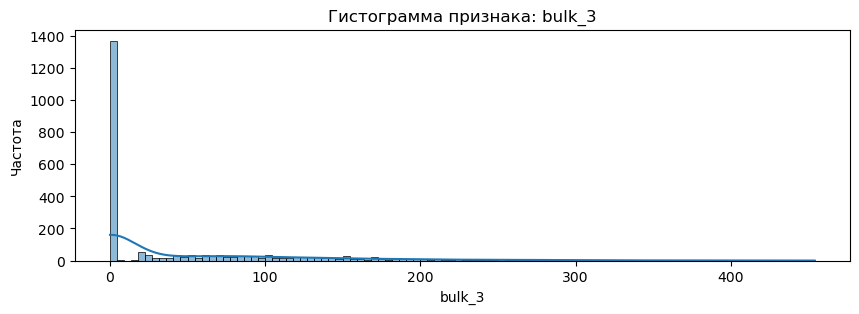

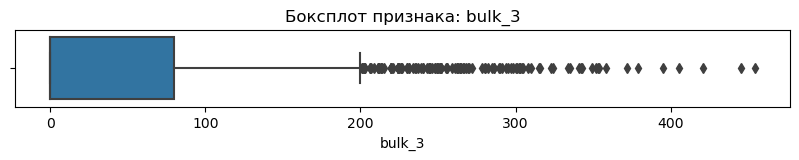

--------------------------------------------------------------------------------------------------------------
Процент нулевых значений в bulk_4: 65.14%
Описательная статистика: bulk_4


count    2329.000000
mean       37.303564
std        58.643238
min         0.000000
25%         0.000000
50%         0.000000
75%        77.000000
max       281.000000
Name: bulk_4, dtype: float64

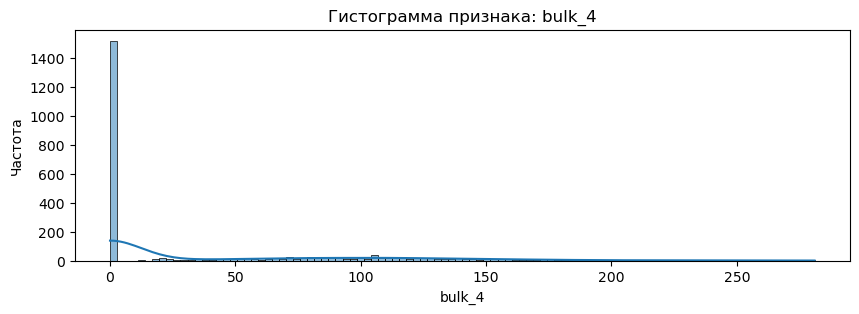

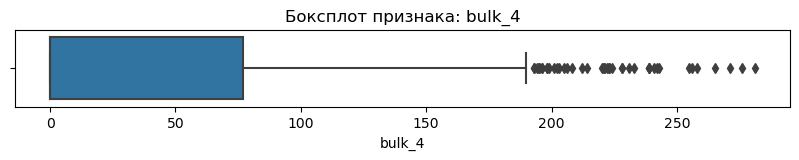

--------------------------------------------------------------------------------------------------------------
Процент нулевых значений в bulk_5: 97.72%
Описательная статистика: bulk_5


count    2329.000000
mean        2.640189
std        22.402293
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       603.000000
Name: bulk_5, dtype: float64

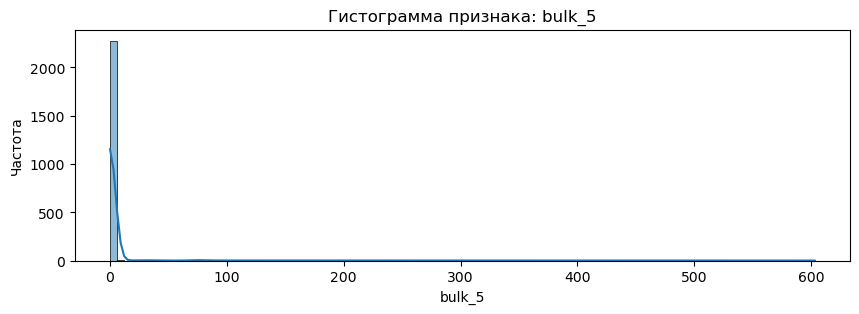

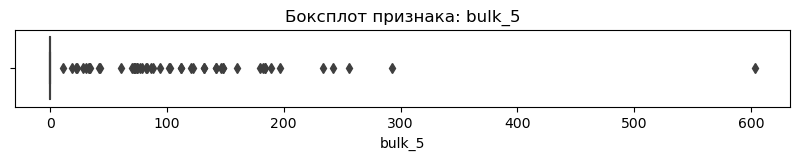

--------------------------------------------------------------------------------------------------------------
Процент нулевых значений в bulk_6: 81.19%
Описательная статистика: bulk_6


count    2329.000000
mean       22.430228
std        55.790873
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       503.000000
Name: bulk_6, dtype: float64

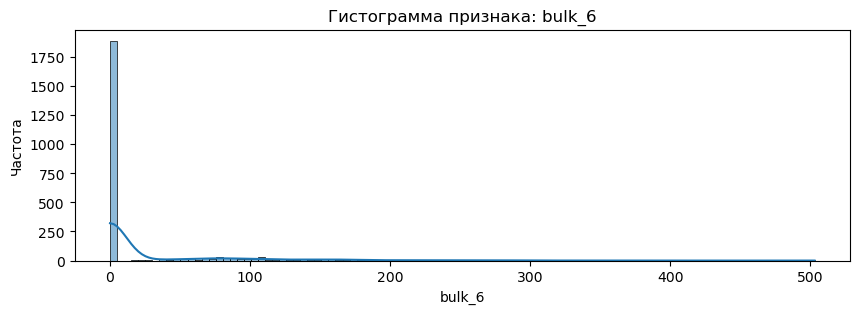

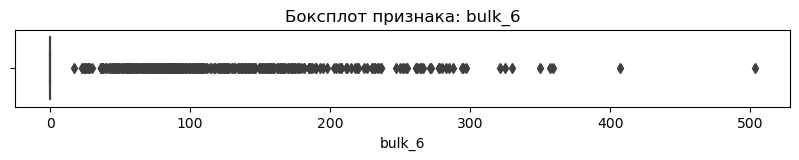

--------------------------------------------------------------------------------------------------------------
Процент нулевых значений в bulk_7: 99.44%
Описательная статистика: bulk_7


count    2329.000000
mean        2.004723
std        30.676234
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       772.000000
Name: bulk_7, dtype: float64

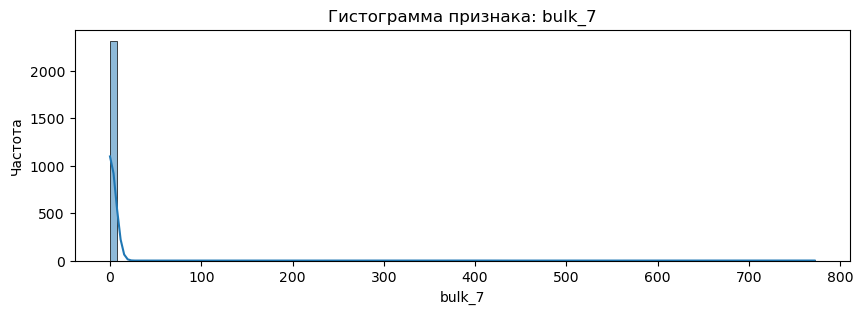

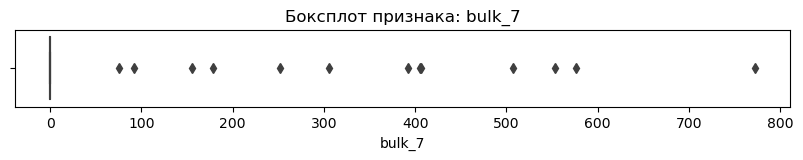

--------------------------------------------------------------------------------------------------------------
Процент нулевых значений в bulk_8: 99.96%
Описательная статистика: bulk_8


count    2329.000000
mean        0.021039
std         1.015340
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        49.000000
Name: bulk_8, dtype: float64

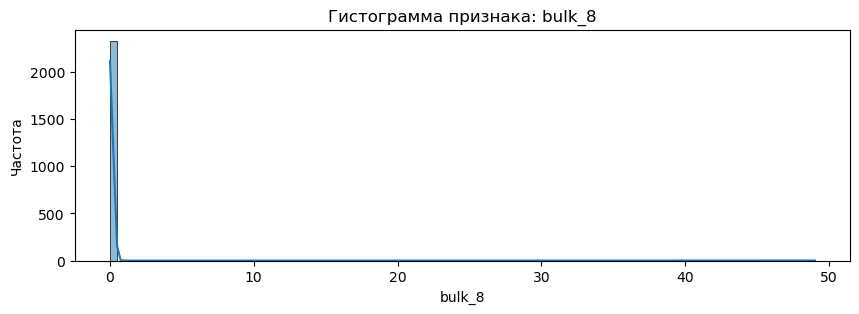

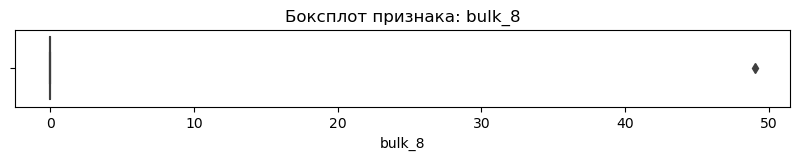

--------------------------------------------------------------------------------------------------------------
Процент нулевых значений в bulk_9: 99.44%
Описательная статистика: bulk_9


count    2329.000000
mean        0.444826
std         6.220641
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       147.000000
Name: bulk_9, dtype: float64

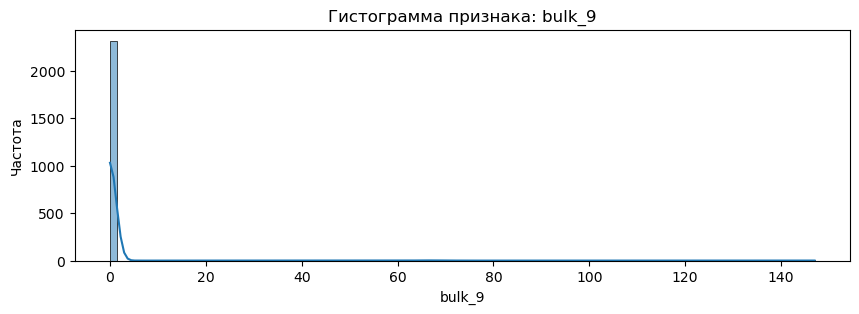

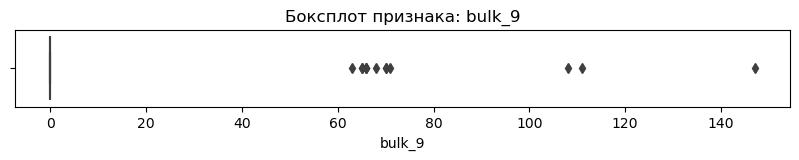

--------------------------------------------------------------------------------------------------------------
Процент нулевых значений в bulk_10: 93.86%
Описательная статистика: bulk_10


count    2329.000000
mean        5.052812
std        20.917800
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       159.000000
Name: bulk_10, dtype: float64

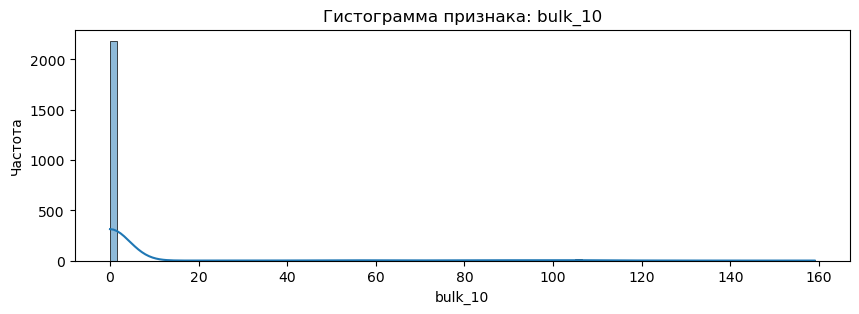

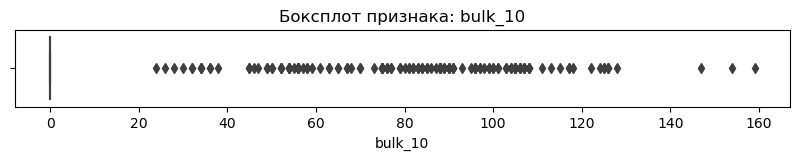

--------------------------------------------------------------------------------------------------------------
Процент нулевых значений в bulk_11: 94.42%
Описательная статистика: bulk_11


count    2329.000000
mean        4.245170
std        22.515487
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       313.000000
Name: bulk_11, dtype: float64

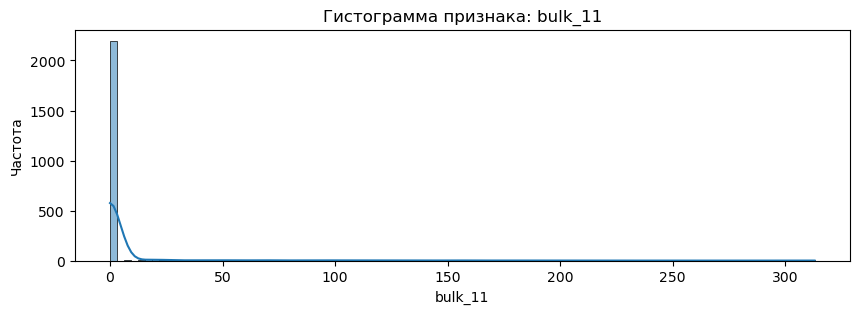

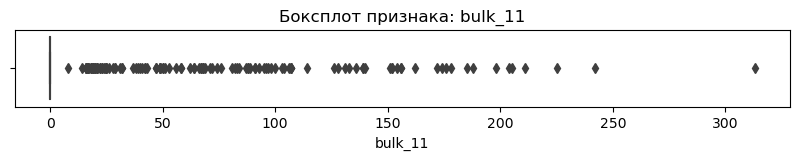

--------------------------------------------------------------------------------------------------------------
Процент нулевых значений в bulk_12: 22.2%
Описательная статистика: bulk_12


count    2329.000000
mean      208.415629
std       157.062272
min         0.000000
25%       105.000000
50%       206.000000
75%       282.000000
max      1849.000000
Name: bulk_12, dtype: float64

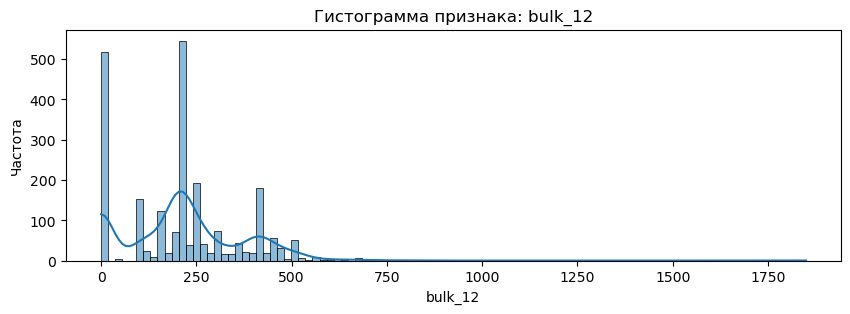

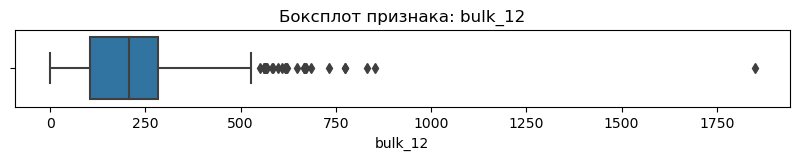

--------------------------------------------------------------------------------------------------------------
Процент нулевых значений в bulk_13: 99.4%
Описательная статистика: bulk_13


count    2329.000000
mean        1.067411
std        14.235055
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       305.000000
Name: bulk_13, dtype: float64

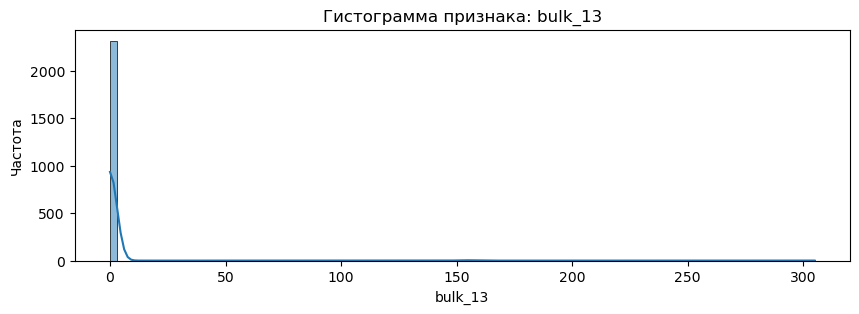

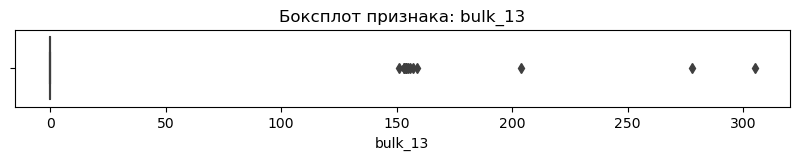

--------------------------------------------------------------------------------------------------------------
Процент нулевых значений в bulk_14: 11.21%
Описательная статистика: bulk_14


count    2329.000000
mean      153.853585
std        81.404354
min         0.000000
25%       105.000000
50%       149.000000
75%       204.000000
max       636.000000
Name: bulk_14, dtype: float64

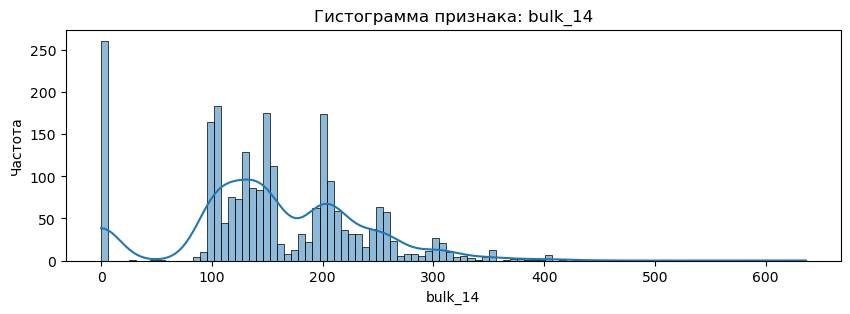

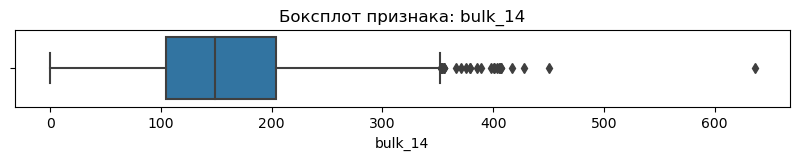

--------------------------------------------------------------------------------------------------------------
Процент нулевых значений в bulk_15: 27.05%
Описательная статистика: bulk_15


count    2329.000000
mean      119.952769
std        84.640443
min         0.000000
25%         0.000000
50%       107.000000
75%       204.000000
max       405.000000
Name: bulk_15, dtype: float64

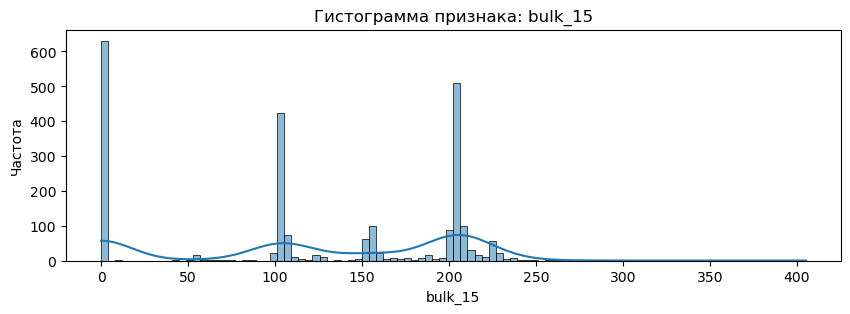

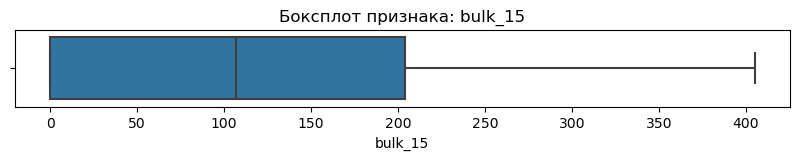

--------------------------------------------------------------------------------------------------------------


In [56]:
for i in range (1, 16):
    null = round(data[f'bulk_{i}'].value_counts()[0] / len(data[f'bulk_{i}']) * 100, 2)
    print(f'Процент нулевых значений в bulk_{i}: {null}%')
    EDA_numeric(data, f'bulk_{i}', bins=100)
    print('-'*110)

**Вывод**: Объединить в один столбец необходимо: `bulk_2`, `bulk_5`, `bulk_7`, `bulk_8`, `bulk_9`, `bulk_13`

In [57]:
data['bulk_rare'] = data['bulk_2'] + data['bulk_5'] + data['bulk_7'] + data['bulk_8'] + data['bulk_9'] + data['bulk_13']
data = data.drop(['bulk_2', 'bulk_7', 'bulk_5', 'bulk_8', 'bulk_9', 'bulk_13'], axis=1)
data.head()

C:\Users\79952\AppData\Local\Temp\ipykernel_16420\1660310810.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['bulk_rare'] = data['bulk_2'] + data['bulk_5'] + data['bulk_7'] + data['bulk_8'] + data['bulk_9'] + data['bulk_13']


,key,temp_first,temp_last,активная_мощность,реактивная_мощность,time,bulk_1,bulk_3,bulk_4,bulk_6,bulk_10,bulk_11,bulk_12,bulk_14,bulk_15,газ_1,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,bulk_rare
0,1,1571.0,1613.0,3.036730,2.142821,1098.0,0.0,0.0,43.0,0.0,0.0,0.0,206.0,150.0,154.0,29.749986,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,1581.0,1602.0,2.139408,1.453357,811.0,0.0,0.0,73.0,0.0,0.0,0.0,206.0,149.0,154.0,12.555561,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,1596.0,1599.0,4.063641,2.937457,655.0,0.0,0.0,34.0,0.0,0.0,0.0,205.0,152.0,153.0,28.554793,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,1601.0,1625.0,2.706489,2.056992,741.0,0.0,0.0,81.0,0.0,0.0,0.0,207.0,153.0,154.0,18.841219,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,1576.0,1602.0,2.252950,1.687991,869.0,0.0,0.0,78.0,0.0,0.0,0.0,203.0,151.0,152.0,5.413692,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Вывод**: объем сыпучих материалов успешно обработан

## `wire_1...wire_9`

Если процент нулевых значений в проволочных материалах будет больше 95%, то будем объединять их в признак `wire_rare`

Процент нулевых значений в wire_1: 0.99%
Описательная статистика: wire_1


count    2329.000000
mean      102.443601
std        43.539993
min         0.000000
25%        73.207679
50%       101.119201
75%       128.091599
max       330.314424
Name: wire_1, dtype: float64

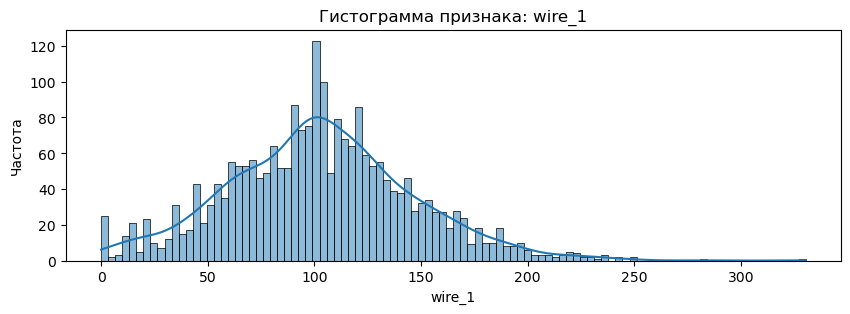

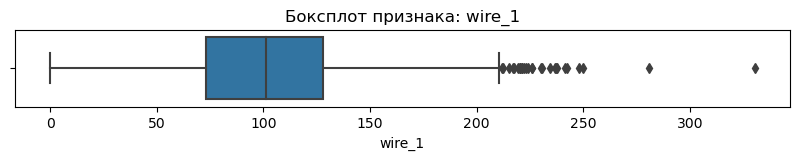

--------------------------------------------------------------------------------------------------------------
Процент нулевых значений в wire_2: 65.18%
Описательная статистика: wire_2


count    2329.000000
mean       17.609859
std        33.624771
min         0.000000
25%         0.000000
50%         0.000000
75%        23.102560
max       282.780152
Name: wire_2, dtype: float64

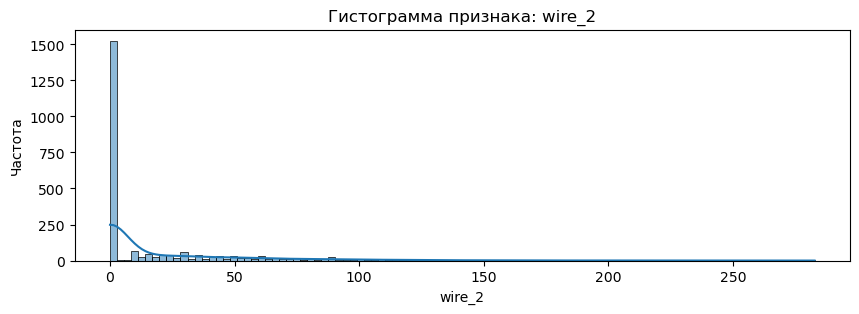

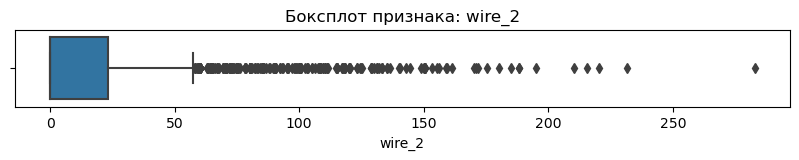

--------------------------------------------------------------------------------------------------------------
Процент нулевых значений в wire_3: 98.33%
Описательная статистика: wire_3


count    2329.000000
mean        3.234916
std        27.942871
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       385.008668
Name: wire_3, dtype: float64

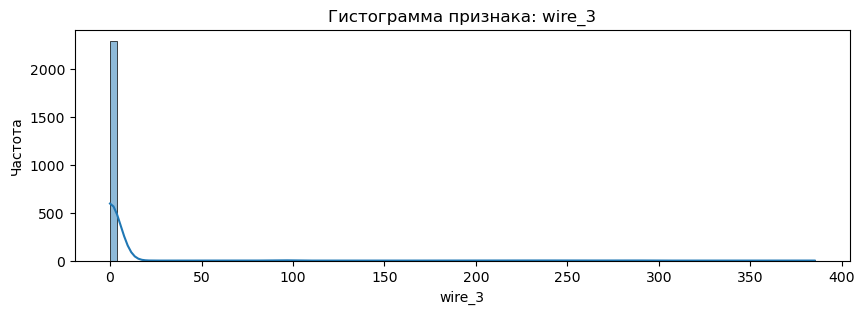

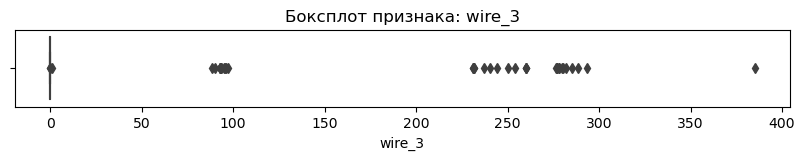

--------------------------------------------------------------------------------------------------------------
Процент нулевых значений в wire_4: 99.48%
Описательная статистика: wire_4


count    2329.000000
mean        0.306550
std         4.757746
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       113.231044
Name: wire_4, dtype: float64

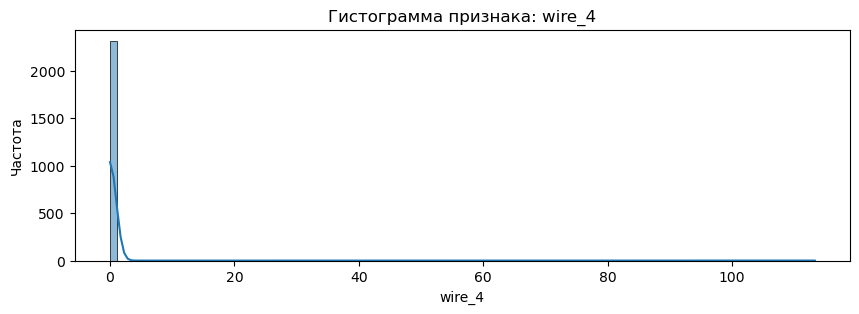

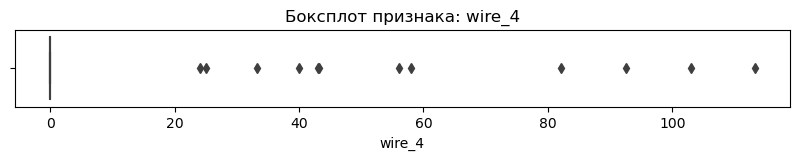

--------------------------------------------------------------------------------------------------------------
Процент нулевых значений в wire_5: 100.0%
Описательная статистика: wire_5


count    2329.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: wire_5, dtype: float64

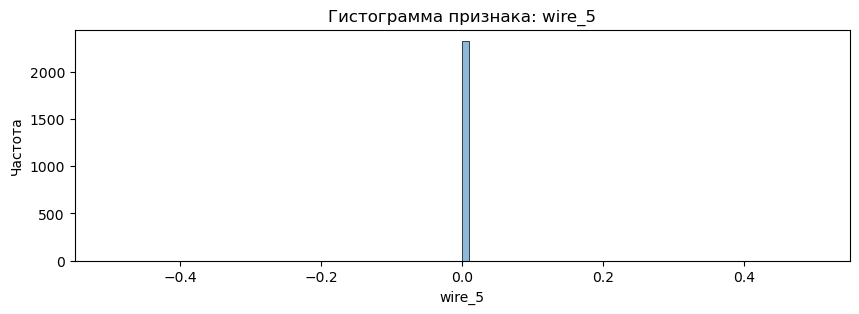

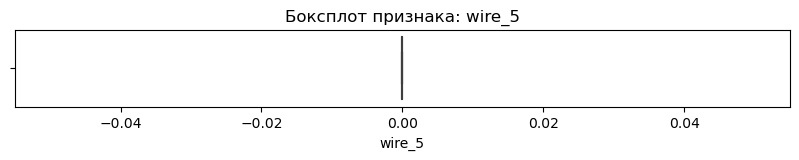

--------------------------------------------------------------------------------------------------------------
Процент нулевых значений в wire_6: 98.07%
Описательная статистика: wire_6


count    2329.000000
mean        0.978820
std         8.693299
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       180.454575
Name: wire_6, dtype: float64

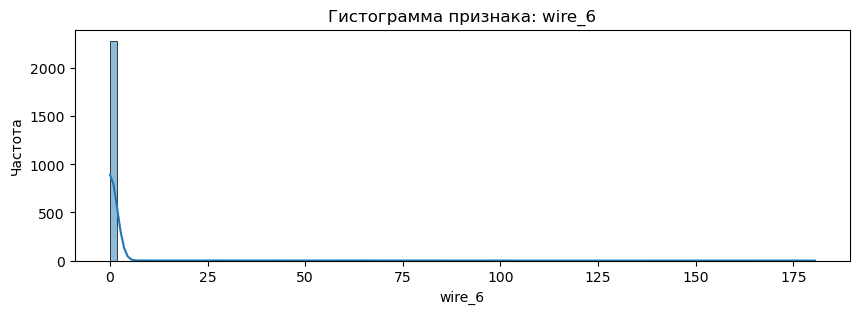

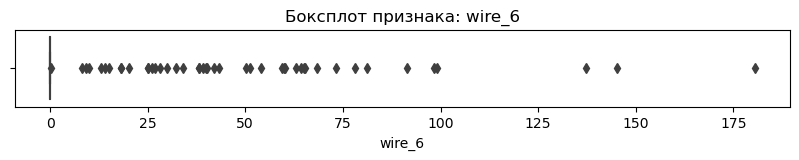

--------------------------------------------------------------------------------------------------------------
Процент нулевых значений в wire_7: 99.83%
Описательная статистика: wire_7


count    2329.000000
mean        0.006361
std         0.205705
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         8.490040
Name: wire_7, dtype: float64

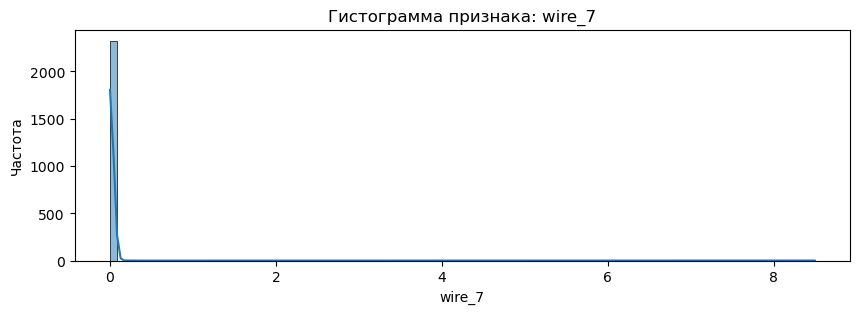

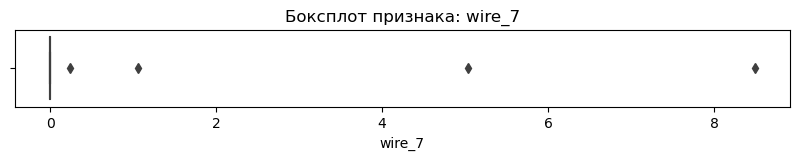

--------------------------------------------------------------------------------------------------------------
Процент нулевых значений в wire_8: 99.44%
Описательная статистика: wire_8


count    2329.000000
mean        0.311311
std         4.402707
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       102.762401
Name: wire_8, dtype: float64

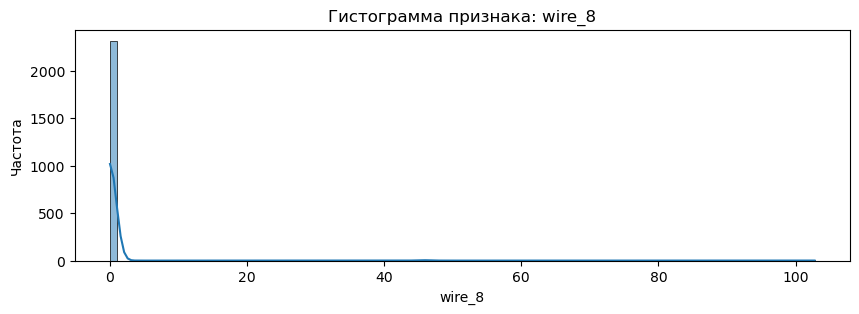

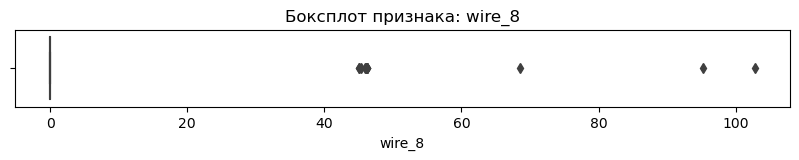

--------------------------------------------------------------------------------------------------------------
Процент нулевых значений в wire_9: 98.97%
Описательная статистика: wire_9


count    2329.000000
mean        0.317113
std         3.456561
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        62.025600
Name: wire_9, dtype: float64

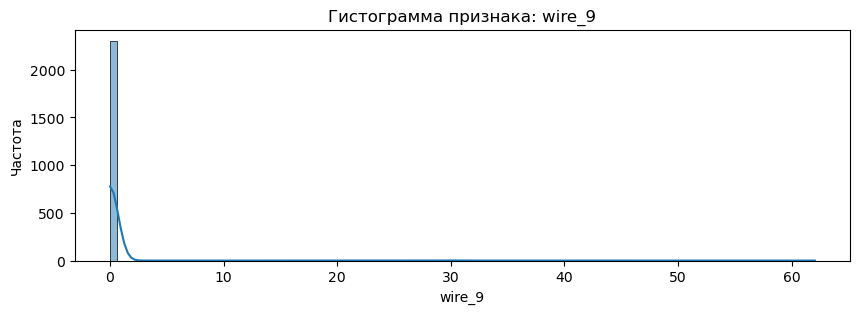

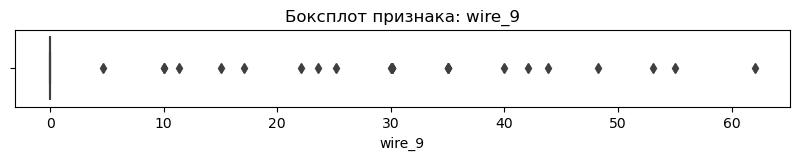

--------------------------------------------------------------------------------------------------------------


In [58]:
for i in range (1, 10):
    null = round(data[f'wire_{i}'].value_counts()[0] / len(data[f'wire_{i}']) * 100, 2)
    print(f'Процент нулевых значений в wire_{i}: {null}%')
    EDA_numeric(data, f'wire_{i}', bins=100)
    print('-'*110)

**Вывод**: объединить в один столбец необходимо: `wire_3`, `wire_4`, `wire_5`, `wire_6`, `wire_7`, `wire_8`, `wire_9`

In [59]:
lst = ['wire_3', 'wire_4', 'wire_5', 'wire_6', 'wire_7', 'wire_8', 'wire_9']
data['wire_rare'] = 0

for i in lst: 
    data['wire_rare'] += data[i]
    
for i in lst: 
    data = data.drop(i, axis=1)
    
data.head()

,key,temp_first,temp_last,активная_мощность,реактивная_мощность,time,bulk_1,bulk_3,bulk_4,bulk_6,bulk_10,bulk_11,bulk_12,bulk_14,bulk_15,газ_1,wire_1,wire_2,bulk_rare,wire_rare
0,1,1571.0,1613.0,3.036730,2.142821,1098.0,0.0,0.0,43.0,0.0,0.0,0.0,206.0,150.0,154.0,29.749986,60.059998,0.00000,0.0,0.0
1,2,1581.0,1602.0,2.139408,1.453357,811.0,0.0,0.0,73.0,0.0,0.0,0.0,206.0,149.0,154.0,12.555561,96.052315,0.00000,0.0,0.0
2,3,1596.0,1599.0,4.063641,2.937457,655.0,0.0,0.0,34.0,0.0,0.0,0.0,205.0,152.0,153.0,28.554793,91.160157,0.00000,0.0,0.0
3,4,1601.0,1625.0,2.706489,2.056992,741.0,0.0,0.0,81.0,0.0,0.0,0.0,207.0,153.0,154.0,18.841219,89.063515,0.00000,0.0,0.0
4,5,1576.0,1602.0,2.252950,1.687991,869.0,0.0,0.0,78.0,0.0,0.0,0.0,203.0,151.0,152.0,5.413692,89.238236,9.11456,0.0,0.0


In [60]:
print(f'Размерность итогвой таблицы {data.shape}')

Размерность итогвой таблицы (2329, 20)


# Корреляционный анализ

Проведем корреляционный анализ полученной таблицы

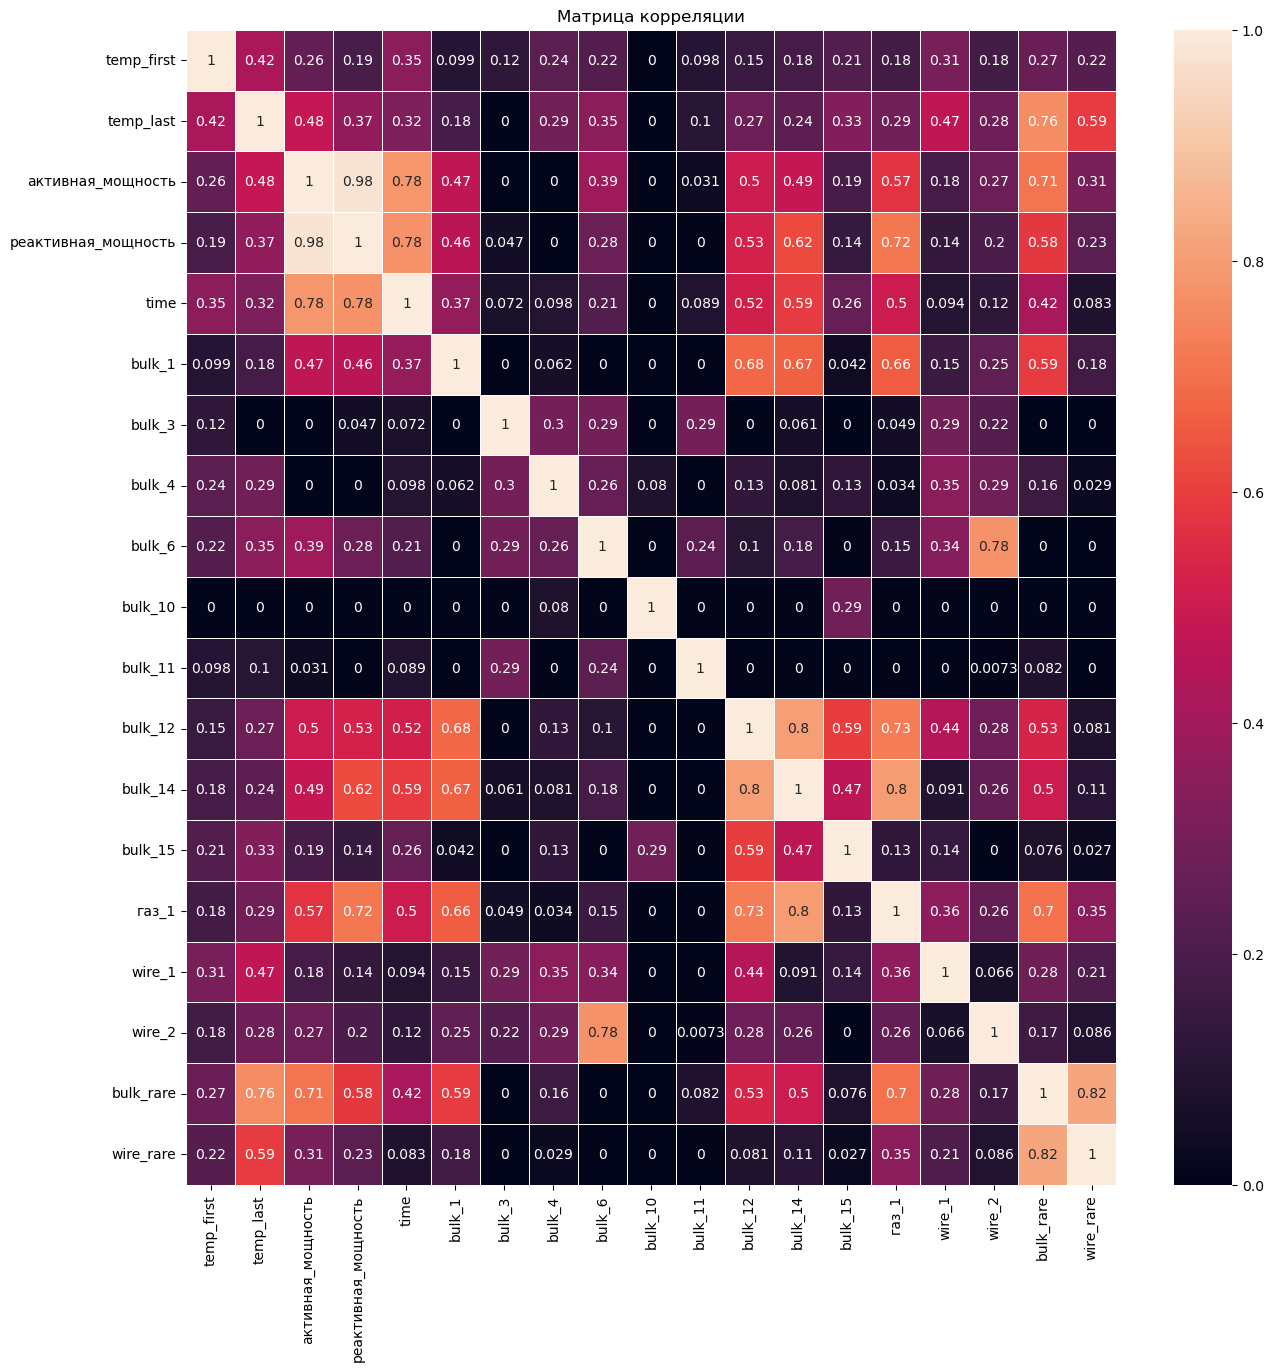

In [61]:
def heatmap_corrmatrix(): 
    data_corr = data.drop(['key'], axis=1)
    corr_matrix = data_corr.phik_matrix(interval_cols = data_corr.columns)
    plt.figure(figsize= (15, 15))
    sns.heatmap(corr_matrix, annot=True, linewidths=0.5)
    plt.title('Матрица корреляции')
    plt.show()
    
heatmap_corrmatrix()

**Вывод**: наблюдается мультиколлинеарность между признаками с реактивной и активной мощностью. Избавимся от реактивной мощности

In [62]:
data = data.drop('реактивная_мощность', axis=1)
data.head()

,key,temp_first,temp_last,активная_мощность,time,bulk_1,bulk_3,bulk_4,bulk_6,bulk_10,bulk_11,bulk_12,bulk_14,bulk_15,газ_1,wire_1,wire_2,bulk_rare,wire_rare
0,1,1571.0,1613.0,3.036730,1098.0,0.0,0.0,43.0,0.0,0.0,0.0,206.0,150.0,154.0,29.749986,60.059998,0.00000,0.0,0.0
1,2,1581.0,1602.0,2.139408,811.0,0.0,0.0,73.0,0.0,0.0,0.0,206.0,149.0,154.0,12.555561,96.052315,0.00000,0.0,0.0
2,3,1596.0,1599.0,4.063641,655.0,0.0,0.0,34.0,0.0,0.0,0.0,205.0,152.0,153.0,28.554793,91.160157,0.00000,0.0,0.0
3,4,1601.0,1625.0,2.706489,741.0,0.0,0.0,81.0,0.0,0.0,0.0,207.0,153.0,154.0,18.841219,89.063515,0.00000,0.0,0.0
4,5,1576.0,1602.0,2.252950,869.0,0.0,0.0,78.0,0.0,0.0,0.0,203.0,151.0,152.0,5.413692,89.238236,9.11456,0.0,0.0


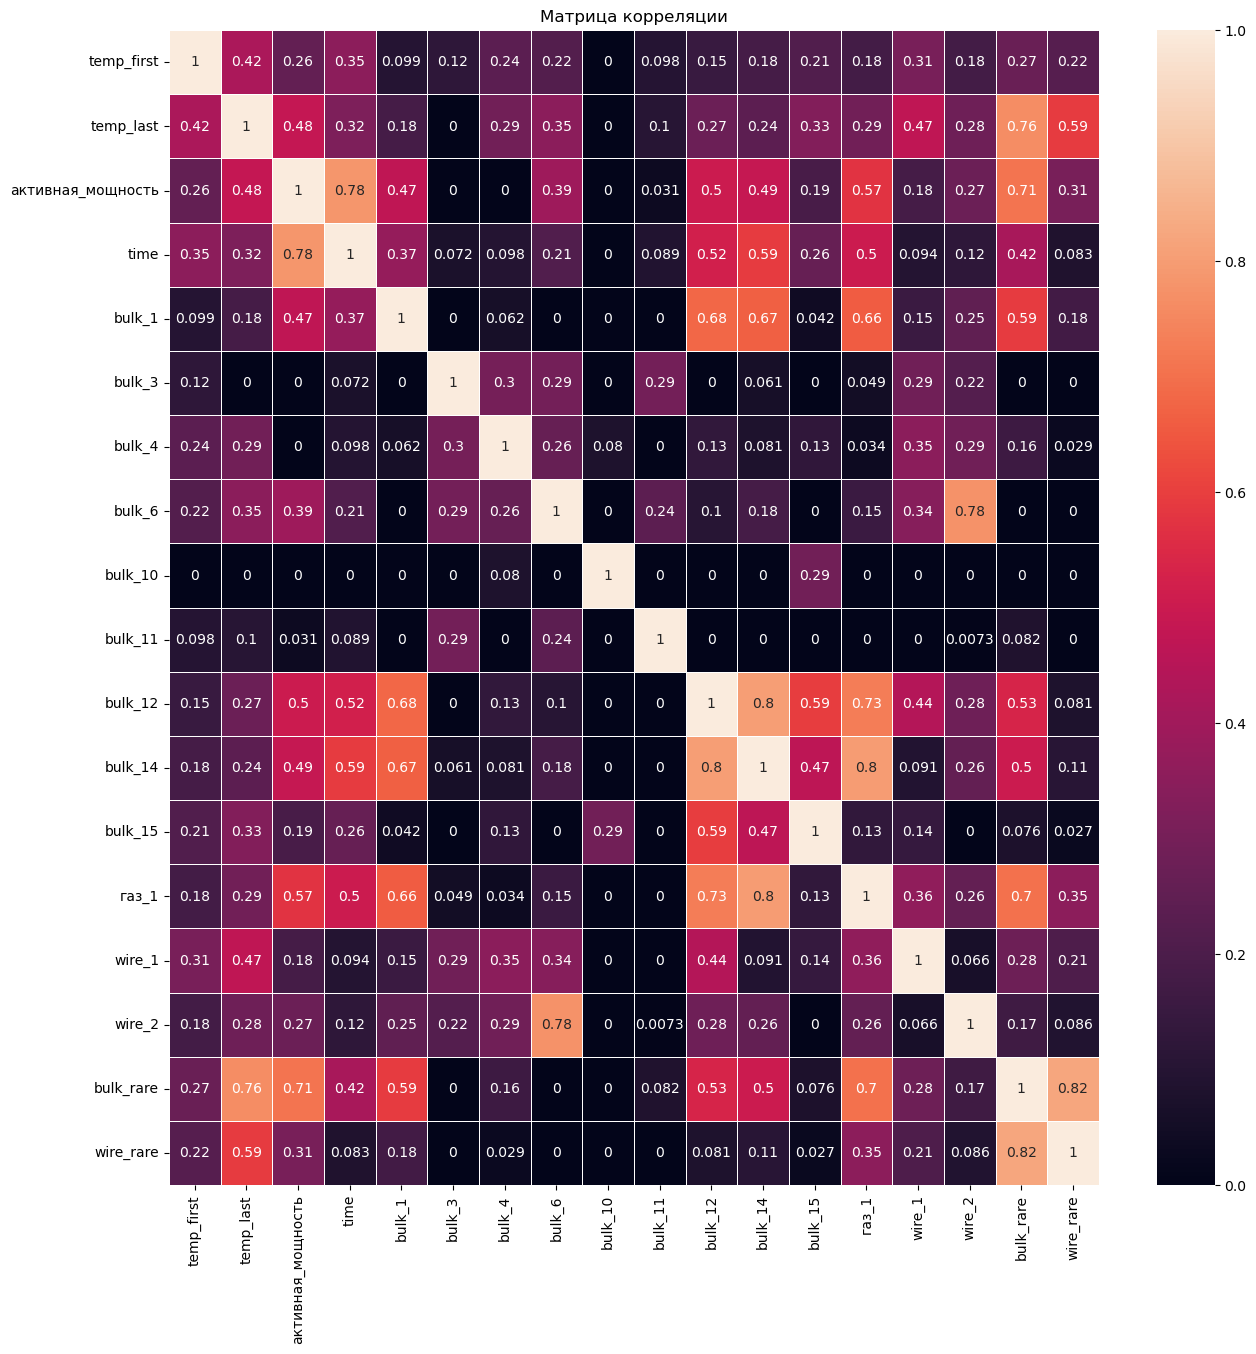

In [63]:
heatmap_corrmatrix()

**Вывод**: теперь мультиколлинеарность отсутствует

# Подготовка данных 

In [64]:
# Разбиение на входные и целевой признаки
X = data.drop(['key', 'temp_last'], axis=1)
y = data['temp_last']

print(f'''Размерность входных признаков {X.shape}
Размерность целевого признака {y.shape}''')

Размерность входных признаков (2329, 17)
Размерность целевого признака (2329,)


In [65]:
# Разбиение на триенировочную и тестовую выборки
RANDOM_STATE = 251124

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    random_state=RANDOM_STATE, 
                                                    test_size=0.25)

In [66]:
shapes = pd.DataFrame({'Размерность': [X_train.shape, 
                             y_train.shape, 
                             X_test.shape, 
                             y_test.shape]},
            index=['X_train', 'y_train', 'X_test', 'y_test'])
shapes

,Размерность
X_train,"(1746, 17)"
y_train,"(1746,)"
X_test,"(583, 17)"
y_test,"(583,)"


**Вывод**: выборки для обучения подготовлены

# Обучение моделей 

Обучим три модели: 
- LightGBM
- Деревья решений под задачу регрессии
- Ридж регрессия

In [67]:
numerical_cols = X_train.columns

In [68]:
# Сборка пайплайна обработки данных
data_preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_cols)
], 
    remainder='passthrough')

In [69]:
# Финальный пайплайн
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor), 
    ('models', Ridge(random_state=RANDOM_STATE))
])

In [70]:
# подбор моделей
param_grid = [
    {
    'models' : [Ridge(random_state=RANDOM_STATE)]
    },
    {
    'models' : [DecisionTreeRegressor(random_state=RANDOM_STATE, max_depth = 7)]  
    },   
    {
    'models' : [LGBMRegressor(random_state=RANDOM_STATE, n_estimators = 150, learning_rate = 0.05)], 
    }
]

In [71]:
grid = GridSearchCV(
        pipe_final, 
        param_grid, 
        cv=5, 
        scoring='neg_mean_absolute_error', 
        n_jobs=-1)

In [72]:
grid.fit(X_train, y_train)
grid.best_params_

{'models': Ridge(random_state=251124)}

In [73]:
grid.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  Index(['temp_first', 'активная_мощность', 'time', 'bulk_1', 'bulk_3', 'bulk_4',
       'bulk_6', 'bulk_10', 'bulk_11', 'bulk_12', 'bulk_14', 'bulk_15',
       'газ_1', 'wire_1', 'wire_2', 'bulk_rare', 'wire_rare'],
      dtype='object'))])),
                ('models', Ridge(random_state=251124))])

**Вывод**: Наилучшей моделью оказалась `Ridge`

In [74]:
print(f'Метрика наилучшей модели: {round(abs(grid.best_score_), 2)}')

Метрика наилучшей модели: 6.48


In [75]:
final_model = grid.best_estimator_

Данная метрика удовлетворяет нашим требованиям. Получим значение метрики на тестовой выборке

In [76]:
y_pred = final_model.predict(X_test)
score = mean_absolute_error(y_test, y_pred)
print(f'Метрика на тестовой выборке: {round(score, 2)}')

Метрика на тестовой выборке: 6.03


**Вывод**: была получена наилучшая модель с метрикой качества 6.03 на тестовой выборке, что нас полностью удовлетворяет

# Анализ важности признаков 

Оценим важность признаков

In [77]:
model = grid.best_estimator_.named_steps['models']

In [78]:
# Веса модели
weights = model.coef_
weights

array([ 5.28692995, -1.59536125,  6.64996834, -1.31111619, -0.03991204,
        0.37805887, -1.16351311,  0.11393919, -0.63814574,  0.1385183 ,
        0.28474226,  0.77910779, -0.90649164,  1.13973848, -1.21013559,
       -1.31727264, -0.17423943])

In [79]:
# Таблица с признаками и весами
feature_weights = pd.DataFrame({'feature': X_train.columns, 
                               'weight': weights})

feature_weights = feature_weights.sort_values(by='weight', 
                                             ascending=False, 
                                             ignore_index=True)
feature_weights

,feature,weight
0,time,6.649968
1,temp_first,5.286930
2,wire_1,1.139738
3,bulk_15,0.779108
4,bulk_4,0.378059
5,bulk_14,0.284742
6,bulk_12,0.138518
7,bulk_10,0.113939
8,bulk_3,-0.039912
9,wire_rare,-0.174239


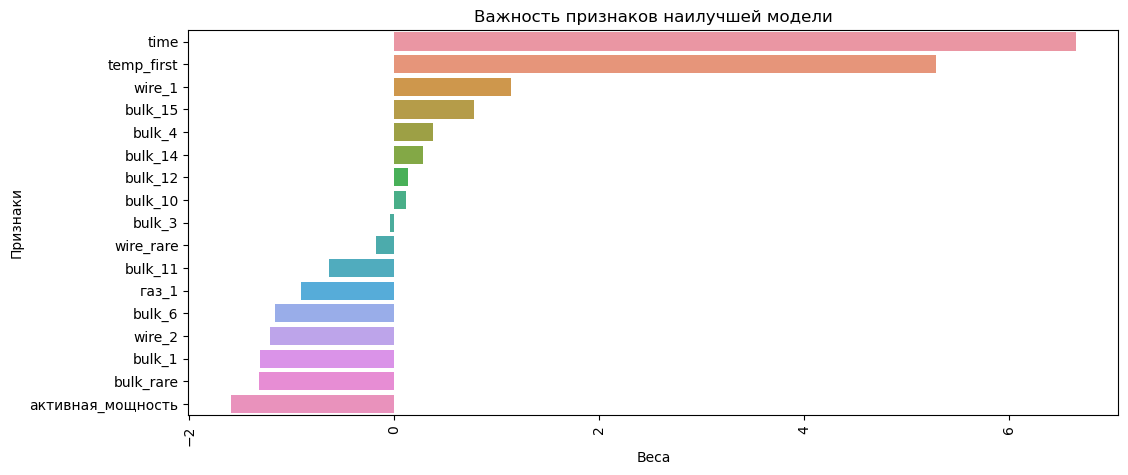

In [80]:
def feature_importance():
    plt.figure(figsize=(12, 5))
    sns.barplot(data=feature_weights, 
               x='weight', 
               y='feature')
    plt.xticks(rotation=90)
    plt.title('Важность признаков наилучшей модели')
    plt.xlabel('Веса')
    plt.ylabel('Признаки')
    plt.show()
    
feature_importance()

**Вывод**: в результате полученных весов модели можно два признака, которые больше всего влияют на конечную температуру стали: 
1. Среднее время цикла легирования сплава `time`
2. Начальная температура `temp_first`

Также есть признаки которые мало влияют на результаты модели: 
1. Объем подаваемого материала `активная мощность`
2. Редкие материалы `bulk_rare`

# Общий вывод 

В ходе данной исследовательской работы были выполнены следующие этапы: 

1. Выгрузка и первичное ознакомление с данными
2. Предобработка данных: скорректирован стиль датасетов, изменены типы данных, обработаны пропуски и дубликаты
3. Проведен первичный исследовательский анализ
4. Все датасеты были объединены в единый датасет
5. Проведен общий исследовательский анализ итогового датасета
6. Корреляционный анализ
7. Подготовка данных и обучение моделей
8. Анализ важности признаков наилучшей модели

В результате была получена наилучшая модель со следующими гиперпараметрами

In [81]:
grid.best_params_

{'models': Ridge(random_state=251124)}

Также по итогам анализа важности признаков был составлен следующий график

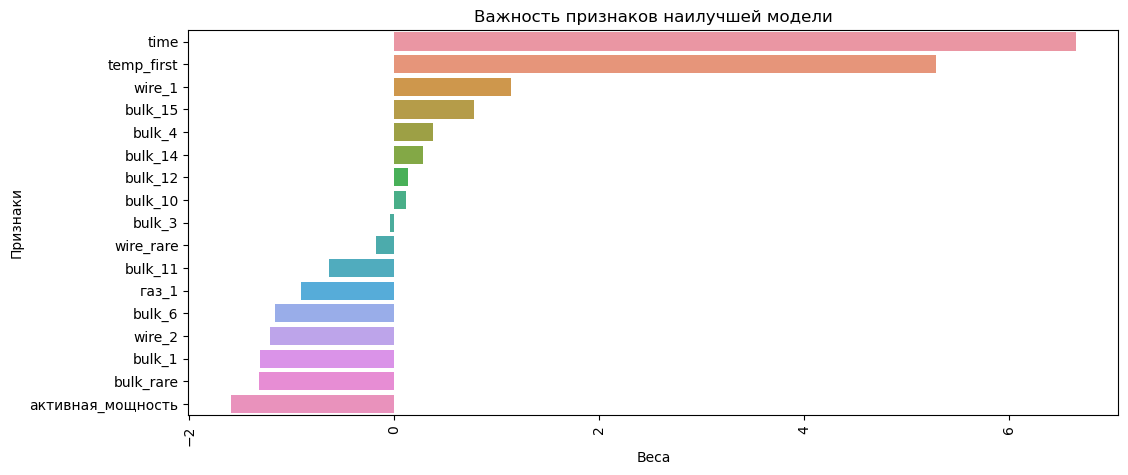

In [82]:
feature_importance()

На основе которого наиболее важными признаками на конечную температуру стали: 
1. Среднее время цикла легирования сплава `time`
2. Начальная температура `temp_first`

**Рекомендации заказчику**

Рекомендуется выбрать вышеупомянутую модель для предсказания конечной температуры стали. 

Также следует учесть при дальнейших решениях те признаки, которые больше всего влияют на величину температуры сплава. Это поможет контролировать подачу электроэнергии, что сэкономит финансы предприятия